<a href="https://colab.research.google.com/github/Prathamesh-kadam/Spectral_Clustering_using_Mahalanobis_distance/blob/main/Copy_of_17_africa_sites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Path to the folder containing the datasets
input_directory = "/content/drive/MyDrive/Results-Africa/"
output_directory = "/content/drive/MyDrive/Calculated_data17/"

# Create the output directory if it does not exist
os.makedirs(output_directory, exist_ok=True)

# List all CSV files in the input directory
datasets = [f for f in os.listdir(input_directory) if f.endswith('.csv')]

# Define the function for processing each dataset
def process_dataset(file_path, dataset_name):
    # Load the data
    try:
        DATA = pd.read_csv(file_path, delimiter=",")
        DATA.columns = DATA.columns.str.strip()
        DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Optionally, fill NaNs with a specific value or method
        DATA.fillna(DATA.mean(), inplace=True)
        #DATA.dropna(inplace=True)
        DATA.reset_index(inplace=True, drop=True)
        print(f"Loaded dataset {dataset_name} with shape: {DATA.shape}")

        # Ensure data is not empty after preprocessing
        if DATA.empty:
            print(f"Warning: Dataset {dataset_name} is empty after preprocessing. Skipping.")
            return
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        return

    # Define the columns you need
    selected_columns = [
        "AOD_F_440",
        "SSA440",
        "EAE_440_870",
        "AAE_440_870",
        "RI_R_440"
    ]

    # Check if all required columns are present
    missing_columns = [col for col in selected_columns if col not in DATA.columns]
    if missing_columns:
        print(f"Warning: Missing columns {missing_columns} in dataset {dataset_name}. Skipping this dataset.")
        return  # Skip this dataset if any required columns are missing

    # Select specific columns
    DATA = DATA[selected_columns]

    # Convert all columns to float64
    for col in DATA.columns:
        DATA[col] = DATA[col].astype(float)

    # Calculate necessary matrices and save them
    N = len(DATA)
    P = len(DATA.columns)

    corr_matrix_R = calculate_corr_matrix(DATA, dataset_name)
    WMD_matrix = calculate_WMD(DATA, dataset_name, corr_matrix_R)
    similarity_matrix_W = calculate_similarity_matrix(DATA, dataset_name, WMD_matrix, k=5)
    diagonal_matrix_D = calculate_diagonal_matrix(dataset_name, similarity_matrix_W)
    regularized_laplacian_matrix_L = calculate_regularized_laplacian_matrix(dataset_name, similarity_matrix_W, diagonal_matrix_D)

    eigenvalues_L, eigenvectors_L = np.linalg.eigh(regularized_laplacian_matrix_L)
    eigenvectors_P = calculate_k_smallest_eigenvectors(dataset_name, eigenvalues_L, eigenvectors_L, k=5)


def calculate_corr_matrix(DATA, dataset_name):
    corr_matrix = np.corrcoef(DATA.values, rowvar=False)
    corr_matrix_data = pd.DataFrame(corr_matrix)

    output_path = os.path.join(output_directory, dataset_name)
    os.makedirs(output_path, exist_ok=True)

    corr_matrix_data.to_csv(os.path.join(output_path, "corr_matrix_R.csv"))

    return corr_matrix


def calculate_WMD(DATA, dataset_name, corr_matrix):
    N = len(DATA)
    WMD = np.zeros((N, N), dtype=np.float64)

    for i in range(N):
        for j in range(i, N):
            X = np.array(DATA.loc[i])
            Y = np.array(DATA.loc[j])
            ans = np.dot(corr_matrix, X - Y)
            ans = np.dot(np.transpose(X - Y), ans)
            WMD[i][j] = math.sqrt(ans)

    # Make WMD symmetric
    WMD = WMD + WMD.T - np.diag(WMD.diagonal())

    WMD_data = pd.DataFrame(WMD)
    output_path = os.path.join(output_directory, dataset_name)
    WMD_data.to_csv(os.path.join(output_path, "WMD_matrix.csv"))

    return WMD


def calculate_similarity_matrix(DATA, dataset_name, WMD, k=3, z=3):
    N = len(DATA)
    similarity_matrix = np.zeros((N, N), dtype=np.float64)
    k_nn = np.zeros((N, N), dtype=np.bool_)

    for i in range(N):
        neighbor_WMD = WMD[i].copy()
        neighbor_WMD[i] = math.inf
        for j in range(k):
            min_WMD = min(neighbor_WMD)
            idx_neighbor = np.where(neighbor_WMD == min_WMD)[0][0]
            neighbor_WMD[idx_neighbor] = math.inf
            k_nn[i][idx_neighbor] = 1

    knn_data = pd.DataFrame(k_nn)
    output_path = os.path.join(output_directory, dataset_name)
    knn_data.to_csv(os.path.join(output_path, "k_nn_data.csv"))

    for i in range(N):
        for j in range(i, N):
            if k_nn[i][j] and k_nn[j][i]:
                coeff = (WMD[i][j] ** 2) / (2 * z)
                similarity_matrix[i][j] = math.exp(-coeff)
                similarity_matrix[j][i] = similarity_matrix[i][j]

    similarity_matrix_data = pd.DataFrame(similarity_matrix)
    similarity_matrix_data.to_csv(os.path.join(output_path, "similarity_matrix.csv"))

    return similarity_matrix


def calculate_diagonal_matrix(dataset_name, W):
    D = np.diag(W.sum(axis=1)) + np.eye(W.shape[0]) * 1e-5
    D_data = pd.DataFrame(D)

    output_path = os.path.join(output_directory, dataset_name)
    D_data.to_csv(os.path.join(output_path, "diagonal_matrix.csv"))

    return D


def calculate_regularized_laplacian_matrix(dataset_name, W, D):
    L = D - W
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    regularized_L = D_inv_sqrt @ L @ D_inv_sqrt + 1e-5 * np.eye(D.shape[0])

    regularized_L_data = pd.DataFrame(regularized_L)
    output_path = os.path.join(output_directory, dataset_name)
    regularized_L_data.to_csv(os.path.join(output_path, "regularized_laplacian_matrix.csv"))

    return regularized_L


def calculate_k_smallest_eigenvectors(dataset_name, eigenvalues, eigenvectors, k):
    k_smallest_eig_V = eigenvectors[:, :k]
    k_smallest_eig_V /= np.linalg.norm(k_smallest_eig_V, axis=1, keepdims=True)
    np.nan_to_num(k_smallest_eig_V, copy=False, nan=(1 / np.sqrt(k)))

    eig_V_data = pd.DataFrame(k_smallest_eig_V)
    output_path = os.path.join(output_directory, dataset_name)
    eig_V_data.to_csv(os.path.join(output_path, f"{k}_eigenvectors.csv"))

    return k_smallest_eig_V

# Iterate over each dataset and process
for dataset in datasets:
    dataset_name = dataset.replace(".csv", "")
    file_path = os.path.join(input_directory, dataset)
    process_dataset(file_path, dataset_name)


Loaded dataset Mongu_Inn-inver_op with shape: (430, 57)
Loaded dataset CATUC_Bamenda-inver_op with shape: (218, 57)
Loaded dataset IER_Cinzana-inver_op with shape: (598, 57)
Loaded dataset ICIPE-Mbita-inver_op with shape: (48, 57)
Loaded dataset CRPSM_Malindi-inver_op with shape: (40, 57)
Loaded dataset Tamanrasset_INM-inver_op with shape: (411, 57)
Loaded dataset Cairo_EMA_2-inver_op with shape: (1246, 57)
Loaded dataset Zinder_Airport_op with shape: (705, 57)
Loaded dataset Dakar-inver_op with shape: (1569, 57)
Loaded dataset Skukuza-inver_op with shape: (249, 57)


<ipython-input-20-8ff4702150e6>:165: RuntimeWarning: invalid value encountered in divide
  k_smallest_eig_V /= np.linalg.norm(k_smallest_eig_V, axis=1, keepdims=True)
<ipython-input-20-8ff4702150e6>:165: RuntimeWarning: invalid value encountered in divide
  k_smallest_eig_V /= np.linalg.norm(k_smallest_eig_V, axis=1, keepdims=True)


Loaded dataset Henties_Bay-inver_op with shape: (15, 57)
Loaded dataset SEGC_Lope_Gabon-inver_op with shape: (246, 57)
Loaded dataset Ilorin-inver_op with shape: (1353, 57)
Loaded dataset Saada-inver_op with shape: (435, 57)
Loaded dataset Bujumbura-inver_op with shape: (101, 57)
Loaded dataset Izana-inver_op with shape: (45, 57)
Loaded dataset Banizoumbou-inver_op with shape: (1729, 57)


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
DATA = pd.read_csv("/content/drive/MyDrive/Results-Africa/Banizoumbou-inver_op.csv", delimiter=",")
data_types = DATA.dtypes
print("Data types of all columns:")
print(data_types)


Data types of all columns:
YYYY             int64
MM               int64
Day              int64
JD               int64
AOD_T_440      float64
AOD_T_675      float64
AOD_T_870      float64
AOD_T_1020     float64
AOD_F_440      float64
AOD_F_675      float64
AOD_F_870      float64
AOD_F_1020     float64
AOD_C_440      float64
AOD_C_675      float64
AOD_C_870      float64
AOD_C_1020     float64
EAE_440_870    float64
SSA440         float64
SSA675         float64
SSA870         float64
SSA1020        float64
AAOD440        float64
AAOD675        float64
AAOD870        float64
AAOD1020       float64
AAE_440_870    float64
RI_R_440       float64
RI_R_675       float64
RI_R_870       float64
RI_R_1020      float64
RI_I_440       float64
RI_I_675       float64
RI_I_870       float64
RI_I_1020      float64
LR_440         float64
LR_675         float64
LR_870         float64
LR_1020        float64
DPR_440        float64
DPR_675        float64
DPR_870        float64
DPR_1020       float64
PWV    

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

num_clusters = 4
eigenvector_filename = "5_eigenvectors.csv"  # This is the name of the eigenvector file in each folder

def perform_clustering_and_save(file_path, num_clusters=4):
    # Read the eigenvector matrix
    X = pd.read_csv(file_path, delimiter=",")

    # Initialize KMeans
    kmeans = KMeans(
        n_clusters=num_clusters, init="k-means++", random_state=2, max_iter=300, tol=1e-1
    )
    kmeans.fit(X)

    # Get the predicted cluster labels
    pred = kmeans.labels_

    # Create a DataFrame for the cluster predictions
    cluster_prediction_data = pd.DataFrame(pred, columns=["Labels"])

    # Determine the output directory (same as the input file's directory)
    output_directory = os.path.dirname(file_path)

    # Save the cluster prediction results
    filename = "cluster_prediction.csv"
    full_path = os.path.join(output_directory, filename)
    np.savetxt(full_path, pred, delimiter=',', fmt='%f')

    print(f"Cluster prediction matrix saved at: {full_path}")

def process_all_datasets(root_directory, eigenvector_filename, num_clusters=4):
    # Iterate over all subdirectories in the root directory
    for dataset_folder in os.listdir(root_directory):
        dataset_folder_path = os.path.join(root_directory, dataset_folder)

        if os.path.isdir(dataset_folder_path):
            # Look for the eigenvector file in the current dataset folder
            eigenvector_file_path = os.path.join(dataset_folder_path, eigenvector_filename)

            # Debugging statement to print the expected file path
            print(f"Looking for file at: {eigenvector_file_path}")

            if os.path.exists(eigenvector_file_path):
                print(f"Processing dataset folder: {dataset_folder}")
                perform_clustering_and_save(eigenvector_file_path, num_clusters)
            else:
                print(f"Eigenvector file not found in: {dataset_folder}. Skipping this folder.")

# Specify the root directory where all dataset folders are located
root_directory = "/content/drive/MyDrive/Calculated_data17"

# Process all datasets
process_all_datasets(root_directory, eigenvector_filename, num_clusters)


Looking for file at: /content/drive/MyDrive/Calculated_data17/Mongu_Inn-inver_op/5_eigenvectors.csv
Processing dataset folder: Mongu_Inn-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Mongu_Inn-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/CATUC_Bamenda-inver_op/5_eigenvectors.csv
Processing dataset folder: CATUC_Bamenda-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/CATUC_Bamenda-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/IER_Cinzana-inver_op/5_eigenvectors.csv
Processing dataset folder: IER_Cinzana-inver_op


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/IER_Cinzana-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/ICIPE-Mbita-inver_op/5_eigenvectors.csv
Processing dataset folder: ICIPE-Mbita-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/ICIPE-Mbita-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/CRPSM_Malindi-inver_op/5_eigenvectors.csv
Processing dataset folder: CRPSM_Malindi-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/CRPSM_Malindi-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Tamanrasset_INM-inver_op/5_eigenvectors.csv
Processing dataset folder: Tamanrasset_INM-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Tamanrasset_INM-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calc

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Zinder_Airport_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Dakar-inver_op/5_eigenvectors.csv
Processing dataset folder: Dakar-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Dakar-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Skukuza-inver_op/5_eigenvectors.csv
Processing dataset folder: Skukuza-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Skukuza-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/5_eigenvectors.csv
Processing dataset folder: Henties_Bay-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/SEGC_Lope_Gabon-inver_op/5_eigenvecto

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Ilorin-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Saada-inver_op/5_eigenvectors.csv
Processing dataset folder: Saada-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Saada-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Bujumbura-inver_op/5_eigenvectors.csv
Processing dataset folder: Bujumbura-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Bujumbura-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Izana-inver_op/5_eigenvectors.csv
Processing dataset folder: Izana-inver_op
Cluster prediction matrix saved at: /content/drive/MyDrive/Calculated_data17/Izana-inver_op/cluster_prediction.csv
Looking for file at: /content/drive/MyDrive/Calculated_data17/Banizoumbou-inver_op/5_eigenvectors.csv
Processing 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex


Centroid Values and Percentages for EAE_440_870 vs SSA440:
Cluster 0: Centroid (1.62, 0.88) - 44.6% of data points
Cluster 1: Centroid (1.45, 0.89) - 27.7% of data points
Cluster 2: Centroid (1.75, 0.88) - 21.8% of data points
Cluster 3: Centroid (1.22, 0.86) - 5.9% of data points

Centroid Values and Percentages for EAE_440_870 vs AOD_F_440:
Cluster 0: Centroid (1.65, 0.65) - 40.6% of data points
Cluster 1: Centroid (1.45, 0.49) - 31.7% of data points
Cluster 2: Centroid (1.63, 1.05) - 26.7% of data points
Cluster 3: Centroid (1.38, 2.11) - 1.0% of data points

Centroid Values and Percentages for EAE_440_870 vs AAE_440_870:
Cluster 0: Centroid (1.69, 1.34) - 38.6% of data points
Cluster 1: Centroid (1.55, 1.50) - 35.6% of data points
Cluster 2: Centroid (1.44, 1.15) - 19.8% of data points
Cluster 3: Centroid (1.41, 1.96) - 5.9% of data points

Centroid Values and Percentages for EAE_440_870 vs DPR_440:
Cluster 0: Centroid (1.71, 0.00) - 41.6% of data points
Cluster 1: Centroid (1.57,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs RI_R_440:
Cluster 0: Centroid (1.70, 1.50) - 43.6% of data points
Cluster 1: Centroid (1.56, 1.45) - 32.7% of data points
Cluster 2: Centroid (1.42, 1.50) - 17.8% of data points
Cluster 3: Centroid (1.22, 1.50) - 5.9% of data points


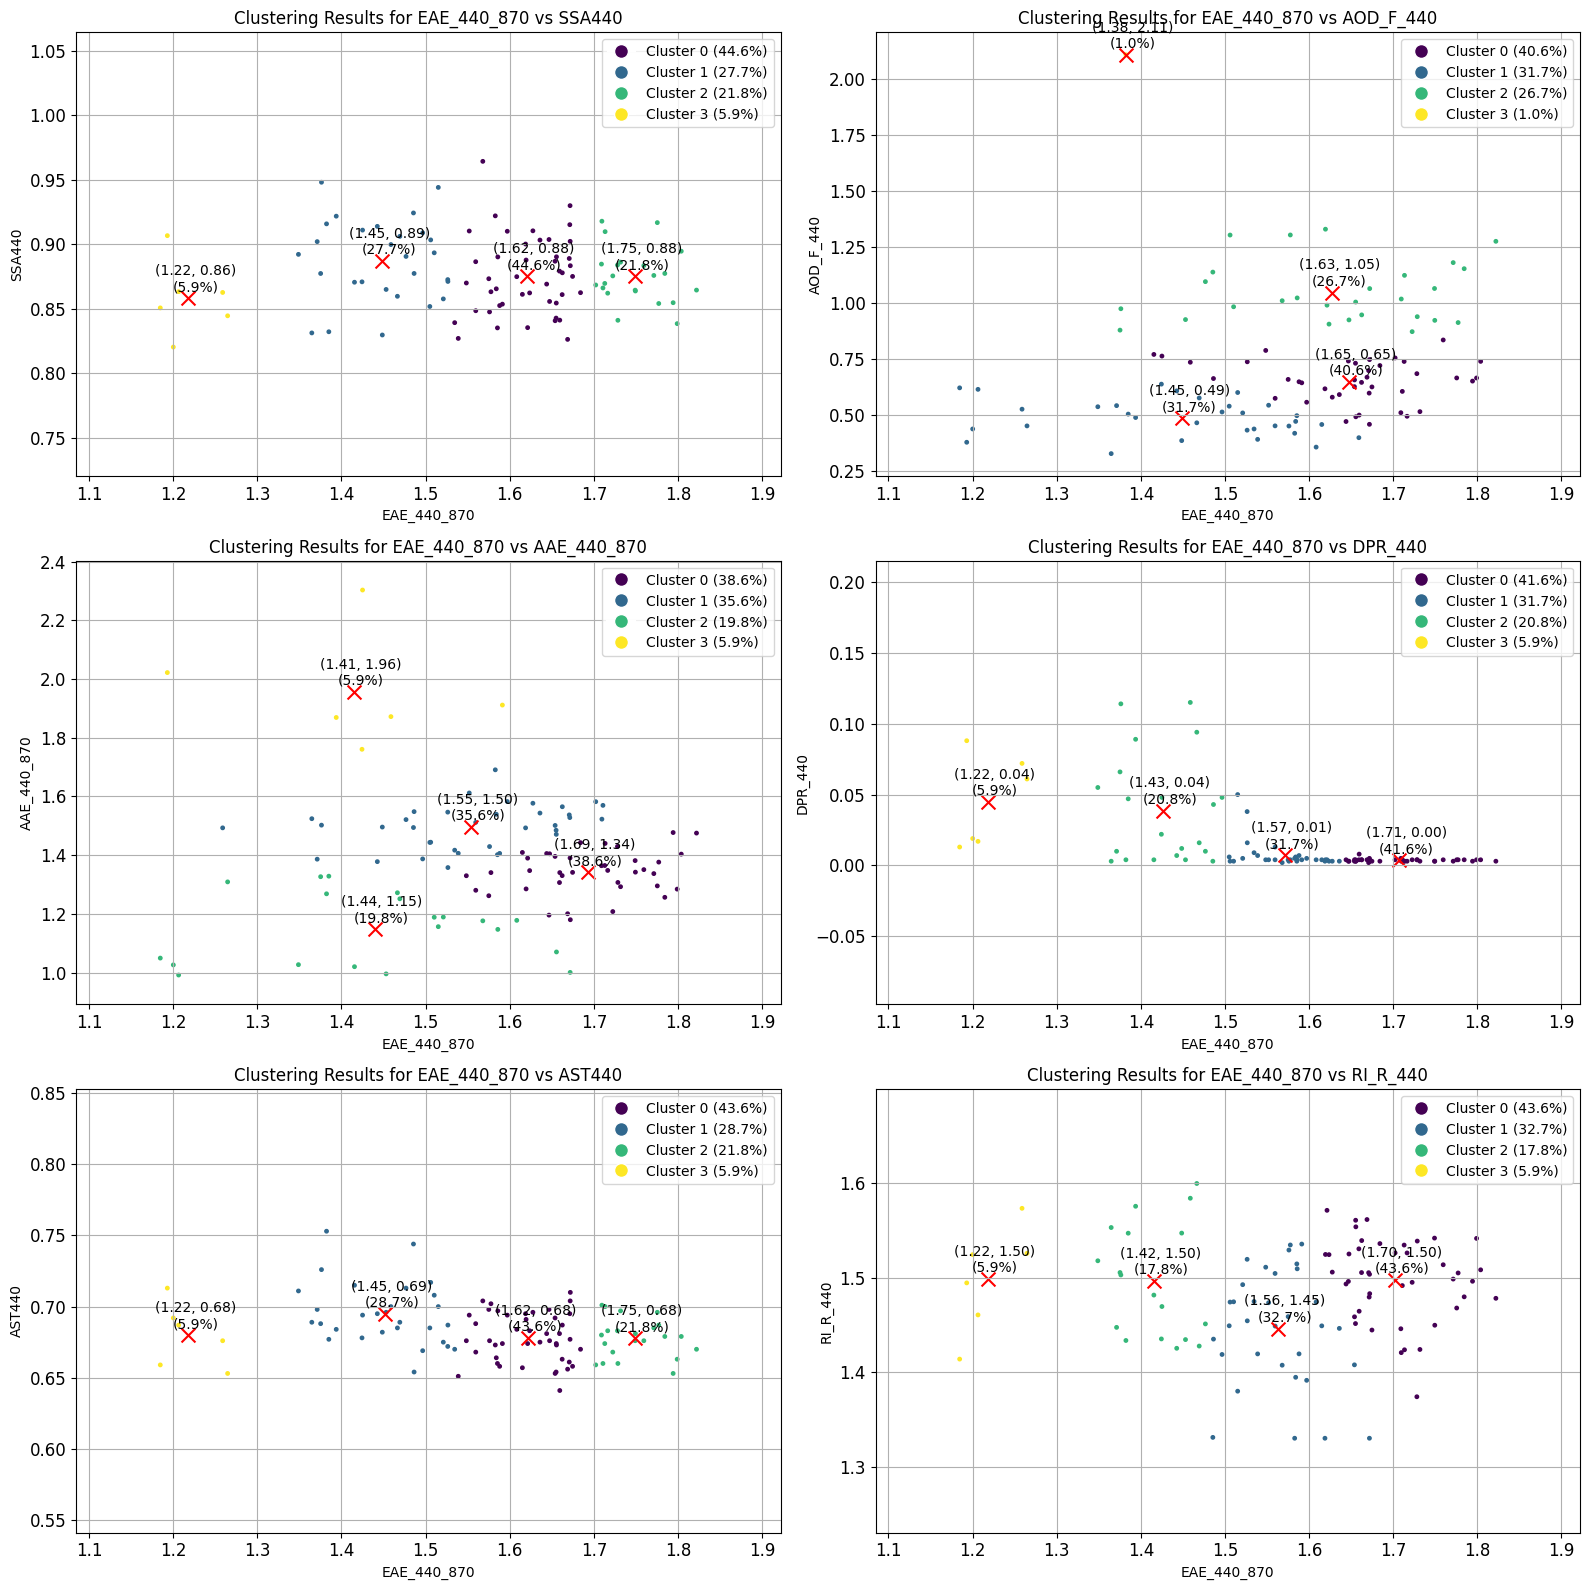

In [ ]:
#DAKAR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Results-Africa/Bujumbura-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))
cluster_predictions=('/content/drive/MyDrive/Calculated_data17/Bujumbura-inver_op/cluster_prediction.csv')

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        # If there are empty clusters, reassign to nearest cluster
        distances = pairwise_distances_argmin_min(centroids, centroids)
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(distances[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on percentage
def reorder_clusters(centroids, labels):
    percentages = calculate_cluster_percentages(labels)
    sorted_clusters = sorted(percentages.items(), key=lambda x: -x[1])  # Sort by percentage, descending
    cluster_order = [cluster for cluster, _ in sorted_clusters]

    # Create a mapping from old label to new label
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_order)}

    # Reassign labels based on the new order
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[cluster_order]

    return new_centroids, new_labels

# Perform clustering on each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Ensure numeric data
    original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
    original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

    # Extract features and drop rows with non-numeric values
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Handle empty clusters
    centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

    # Reorder clusters based on percentage
    centroids, labels = reorder_clusters(centroids, labels)

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(labels)

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate centroids with values and percentages
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    # Improve the readability of axis labels
    axes[i].tick_params(axis='both', labelsize=12)

    # Set axis limits for better visibility
    axes[i].set_xlim(X[feature_x].min() - 0.1, X[feature_x].max() + 0.1)
    axes[i].set_ylim(X[feature_y].min() - 0.1, X[feature_y].max() + 0.1)

    # Set title and labels
    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

    # Create a legend with percentages
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(num_clusters)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].grid(True)

        # Print centroid values and percentages
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os

# Define your main dataset and cluster label paths
results_path = "/content/drive/MyDrive/Results-Africa/"
calculated_data_path = "/content/drive/MyDrive/Calculated_data17/"

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'RI_R_440')
]

# Define fixed cluster types and their percentages for each site
fixed_cluster_data = {
    "Izana-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 100)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 100)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 100)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 100)}
    },
    "ICIPE-Mbita-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 54), 1: ('Mixed Aerosols', 35.42), 2: ('Biomass Burning', 27.08), 3: ('Urban', 10.42)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46), 3: ('Urban', 1)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 34), 1: ('Mixed Aerosols', 22.31), 2: ('Biomass Burning', 13.56), 3: ('Urban', 10.03)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 21.29), 2: ('Biomass Burning', 0.4), 3: ('Urban', 7.23)}
    },
    # Add similar definitions for other sites...
}

# Function to calculate cluster percentages
def calculate_cluster_percentages(labels):
    unique_clusters, counts = np.unique(labels, return_counts=True)
    total_points = len(labels)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(pairwise_distances_argmin_min(centroids, centroids)[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on centroid x-values
def reorder_clusters_by_position(centroids, labels):
    # Get centroid x-values and sort by them
    x_values = centroids[:, 0]
    sorted_indices = np.argsort(x_values)

    # Create a mapping from old cluster labels to new sorted labels
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}

    # Reassign labels based on the new mapping
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[sorted_indices]

    return new_centroids, new_labels

# Function to plot and save clustering results
def plot_clustering_results(X, feature_x, feature_y, centroids, labels, cluster_percentages, ax, site_name):
    scatter = ax.scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis', vmin=0, vmax=3)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Get the fixed cluster data for the current feature pair and site
    fixed_data = fixed_cluster_data.get(site_name, {}).get(f'{feature_x} vs {feature_y}', {})

    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        cluster_type = fixed_data.get(j, ('Unknown', 0))[0]
        ax.annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)\n{cluster_type}', (cx, cy), textcoords='offset points', xytext=(5, 5), ha='center')

    # Create legend with fixed cluster types
    legend_labels = [f'{fixed_data.get(label, ("Unknown", 0))[0]} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(len(centroids))]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(label/len(centroids)), markersize=10) for label in range(len(centroids))]
    ax.legend(handles, legend_labels, loc='upper right')

    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f'{feature_x} vs {feature_y}')
    ax.grid(True)

# Loop through each result file and perform clustering
for file_name in os.listdir(results_path):
    if file_name.endswith(".csv"):
        dataset_name = file_name.replace(".csv", "")

        # Construct file paths
        data_file_path = os.path.join(results_path, file_name)
        cluster_label_file_path = os.path.join(calculated_data_path, dataset_name, "cluster_prediction.csv")

        try:
            # Load the data
            original_data = pd.read_csv(data_file_path)

            # Check if the necessary columns are in the dataset
            missing_features = [feature for pair in feature_pairs for feature in pair if feature not in original_data.columns]
            if missing_features:
                print(f"Skipping {dataset_name}: Missing columns {missing_features}")
                continue

            # Set up the figure and axes for subplots
            fig, axes = plt.subplots(2, 2, figsize=(16, 16))
            axes = axes.flatten()

            # Perform clustering on each feature pair and plot results
            for i, (feature_x, feature_y) in enumerate(feature_pairs):
                if i >= len(axes):
                    break  # Prevent index error if more feature pairs than subplots

                # Ensure numeric data
                original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
                original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

                # Extract features and drop rows with non-numeric values
                X = original_data[[feature_x, feature_y]].dropna()

                if X.empty:
                    print(f"Skipping clustering for {dataset_name}: Feature pair {feature_x} vs {feature_y} has no valid data.")
                    continue

                # Perform KMeans clustering on the selected features
                num_clusters = 4
                kmeans = KMeans(n_clusters=num_clusters, random_state=2)
                kmeans.fit(X)

                # Handle empty clusters
                centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

                # Reorder clusters based on centroid positions
                centroids, labels = reorder_clusters_by_position(centroids, labels)

                # Calculate cluster percentages
                cluster_percentages = calculate_cluster_percentages(labels)

                # Plot clustering results with site-specific data
                plot_clustering_results(X, feature_x, feature_y, centroids, labels, cluster_percentages, axes[i], dataset_name)

            # Save the figure
            plot_path = os.path.join(calculated_data_path, dataset_name, "clustering_results.png")
            plt.tight_layout()
            plt.savefig(plot_path)
            plt.close()
            # Print the path where the image is saved
            print(f"Clustering results for {dataset_name} saved to: {plot_path}")
            # Save the new cluster labels
            cluster_labels_df = pd.DataFrame(labels, columns=['Cluster_Label'])
            cluster_labels_df.to_csv(cluster_label_file_path, index=False)

        except Exception as e:
            print(f"Error processing {dataset_name}: {e}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Bujumbura-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Bujumbura-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Cairo_EMA_2-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Cairo_EMA_2-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for CATUC_Bamenda-inver_op saved to: /content/drive/MyDrive/Calculated_data17/CATUC_Bamenda-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for CRPSM_Malindi-inver_op saved to: /content/drive/MyDrive/Calculated_data17/CRPSM_Malindi-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Dakar-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Dakar-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Henties_Bay-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for ICIPE-Mbita-inver_op saved to: /content/drive/MyDrive/Calculated_data17/ICIPE-Mbita-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for IER_Cinzana-inver_op saved to: /content/drive/MyDrive/Calculated_data17/IER_Cinzana-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Ilorin-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Ilorin-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Izana-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Izana-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Mongu_Inn-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Mongu_Inn-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Saada-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Saada-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for SEGC_Lope_Gabon-inver_op saved to: /content/drive/MyDrive/Calculated_data17/SEGC_Lope_Gabon-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Skukuza-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Skukuza-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Tamanrasset_INM-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Tamanrasset_INM-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Zinder_Airport_op saved to: /content/drive/MyDrive/Calculated_data17/Zinder_Airport_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Banizoumbou-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Banizoumbou-inver_op/clustering_results.png


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os

# Define your main dataset and cluster label paths
results_path = "/content/drive/MyDrive/Results-Africa/"
calculated_data_path = "/content/drive/MyDrive/Calculated_data17/"

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'RI_R_440')
]

# Function to calculate cluster percentages
def calculate_cluster_percentages(labels):
    unique_clusters, counts = np.unique(labels, return_counts=True)
    total_points = len(labels)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        for i in range(num_clusters):
            if i not in unique_labels:
                closest_centroid = np.argmin(pairwise_distances_argmin_min(centroids, centroids)[0])
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on centroid x-values
def reorder_clusters_by_position(centroids, labels):
    x_values = centroids[:, 0]
    sorted_indices = np.argsort(x_values)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[sorted_indices]
    return new_centroids, new_labels

# Function to calculate coarse mode, mean, and median
def calculate_additional_stats(X):
    coarse_mode = X.mode().iloc[0].values if not X.empty else [np.nan] * X.shape[1]
    mean_values = X.mean().values if not X.empty else [np.nan] * X.shape[1]
    median_values = X.median().values if not X.empty else [np.nan] * X.shape[1]
    return coarse_mode, mean_values, median_values

# Function to plot and save clustering results
def plot_clustering_results(X, feature_x, feature_y, centroids, labels, cluster_percentages, ax):
    scatter = ax.scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis', vmin=0, vmax=3)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        ax.annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5, 5), ha='center')
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(len(centroids))]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(label/len(centroids)), markersize=10) for label in range(len(centroids))]
    ax.legend(handles, legend_labels, loc='upper right')
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f'{feature_x} vs {feature_y}')
    ax.grid(True)

# Initialize a list to store centroid data for the CSV file
centroid_data = []

# Loop through each result file and perform clustering
for file_name in os.listdir(results_path):
    if file_name.endswith(".csv"):
        dataset_name = file_name.replace(".csv", "")

        # Construct file paths
        data_file_path = os.path.join(results_path, file_name)
        cluster_label_file_path = os.path.join(calculated_data_path, dataset_name, "cluster_prediction.csv")

        try:
            # Load the data
            original_data = pd.read_csv(data_file_path)

            # Check for missing features
            missing_features = [feature for pair in feature_pairs for feature in pair if feature not in original_data.columns]
            if missing_features:
                print(f"Skipping {dataset_name}: Missing columns {missing_features}")
                continue

            # Set up the figure for plotting
            fig, axes = plt.subplots(2, 2, figsize=(16, 16))
            axes = axes.flatten()

            # Process each feature pair
            for i, (feature_x, feature_y) in enumerate(feature_pairs):
                if i >= len(axes):
                    break

                original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
                original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

                X = original_data[[feature_x, feature_y]].dropna()

                if X.empty:
                    print(f"Skipping clustering for {dataset_name}: Feature pair {feature_x} vs {feature_y} has no valid data.")
                    continue

                num_clusters = 4
                kmeans = KMeans(n_clusters=num_clusters, random_state=2)
                kmeans.fit(X)

                centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)
                centroids, labels = reorder_clusters_by_position(centroids, labels)
                cluster_percentages = calculate_cluster_percentages(labels)

                # Calculate coarse mode, mean, and median for each cluster
                coarse_mode, mean_values, median_values = calculate_additional_stats(X)

                # Store centroids and additional statistics
                for j, (cx, cy) in enumerate(centroids):
                    centroid_data.append({
                        'Dataset': dataset_name,
                        'Cluster': f'Cluster {j}',
                        'Feature': f'{feature_x} vs {feature_y}',
                        'Centroid X': cx,
                        'Centroid Y': cy,
                        'Percentage': cluster_percentages.get(j, 0),
                        'Coarse Mode X': coarse_mode[0],
                        'Coarse Mode Y': coarse_mode[1],
                        'Mean X': mean_values[0],
                        'Mean Y': mean_values[1],
                        'Median X': median_values[0],
                        'Median Y': median_values[1]
                    })

                plot_clustering_results(X, feature_x, feature_y, centroids, labels, cluster_percentages, axes[i])

            plot_path = os.path.join(calculated_data_path, dataset_name, "clustering_results.png")
            plt.tight_layout()
            plt.savefig(plot_path)
            plt.close()
            print(f"Clustering results for {dataset_name} saved to: {plot_path}")
            cluster_labels_df = pd.DataFrame(labels, columns=['Cluster_Label'])
            cluster_labels_df.to_csv(cluster_label_file_path, index=False)

        except Exception as e:
            print(f"Error processing {dataset_name}: {e}")

# Save centroid data to CSV in horizontal format
centroid_df = pd.DataFrame(centroid_data)
centroid_df_pivot = centroid_df.pivot_table(
    index=['Dataset', 'Cluster'],
    columns='Feature',
    values=['Centroid X', 'Centroid Y', 'Percentage', 'Coarse Mode X', 'Coarse Mode Y', 'Mean X', 'Mean Y', 'Median X', 'Median Y']
)
centroid_csv_path = os.path.join(calculated_data_path, "centroid_values_horizontal.csv")
centroid_df_pivot.to_csv(centroid_csv_path)
print(f"Centroid values saved to: {centroid_csv_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering results for Bujumbura-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Bujumbura-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Cairo_EMA_2-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Cairo_EMA_2-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for CATUC_Bamenda-inver_op saved to: /content/drive/MyDrive/Calculated_data17/CATUC_Bamenda-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for CRPSM_Malindi-inver_op saved to: /content/drive/MyDrive/Calculated_data17/CRPSM_Malindi-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Dakar-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Dakar-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Henties_Bay-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for ICIPE-Mbita-inver_op saved to: /content/drive/MyDrive/Calculated_data17/ICIPE-Mbita-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for IER_Cinzana-inver_op saved to: /content/drive/MyDrive/Calculated_data17/IER_Cinzana-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Ilorin-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Ilorin-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Izana-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Izana-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Mongu_Inn-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Mongu_Inn-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Saada-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Saada-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for SEGC_Lope_Gabon-inver_op saved to: /content/drive/MyDrive/Calculated_data17/SEGC_Lope_Gabon-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Skukuza-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Skukuza-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Tamanrasset_INM-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Tamanrasset_INM-inver_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Zinder_Airport_op saved to: /content/drive/MyDrive/Calculated_data17/Zinder_Airport_op/clustering_results.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Clustering results for Banizoumbou-inver_op saved to: /content/drive/MyDrive/Calculated_data17/Banizoumbou-inver_op/clustering_results.png
Centroid values saved to: /content/drive/MyDrive/Calculated_data17/centroid_values_horizontal.csv


In [ ]:
print(original_data.head())
print("Cluster Labels Shape:", cluster_labels.shape)
print("Feature X Shape:", X[feature_x].shape)
print("Feature Y Shape:", X[feature_y].shape)


   YYYY  MM  Day   JD  AOD_T_440  AOD_T_675  AOD_T_870  AOD_T_1020  AOD_F_440  \
0  1995  10   17  290    0.47760     0.4353    0.39480     0.37150    0.25780   
1  1995  10   18  291    0.40910     0.3745    0.34470     0.32575    0.18855   
2  1995  10   24  297    0.46415     0.4185    0.37655     0.35305    0.25775   
3  1995  10   25  298    0.47570     0.4389    0.40460     0.37930    0.18000   
4  1995  10   29  302    0.77280     0.7296    0.67340     0.62820    0.39760   

   AOD_F_675  ...  Al440  Al675  Al870  Al1020  FMF440  FMF675    Lat  Long  \
0    0.20300  ...  0.132  0.277  0.466   0.494  0.5398  0.4663  13.55  2.67   
1    0.13660  ...  0.132  0.277  0.466   0.494  0.4609  0.3648  13.55  2.67   
2    0.19765  ...  0.129  0.278  0.446   0.477  0.5553  0.4723  13.55  2.67   
3    0.11280  ...  0.133  0.283  0.459   0.484  0.3784  0.2570  13.55  2.67   
4    0.33250  ...  0.140  0.292  0.479   0.500  0.5145  0.4557  13.55  2.67   

   Atmos  ID  
0      1 NaN  
1      1

In [ ]:
# Define the target cluster proportions for each site
cluster_proportions = {
    "Izana-inver": {'PDM': 0, 'DDM': 0, 'PD': 100, 'SA': 0, 'NA': 0, 'MA': 0, 'WA': 0, 'PA': 0},
    "ICIPE-Mbita-inver": {'PDM': 35.42, 'DDM': 10.42, 'PD': 0, 'SA': 14.58, 'NA': 4.17, 'MA': 27.08, 'WA': 8.33, 'PA': 54},
    "Henties": {'PDM': 6.67, 'DDM': 6.67, 'PD': 6.67, 'SA': 13.33, 'NA': 6.67, 'MA': 40, 'WA': 20, 'PA': 80},
    "SEGC": {'PDM': 24.8, 'DDM': 8.13, 'PD': 2.03, 'SA': 44.72, 'NA': 1.22, 'MA': 15.04, 'WA': 4.07, 'PA': 65},
    "Taman": {'PDM': 0, 'DDM': 4.14, 'PD': 95.86, 'SA': 0, 'NA': 0, 'MA': 0, 'WA': 0, 'PA': 0},
    "Skukuza-inver": {'PDM': 7.23, 'DDM': 0.4, 'PD': 0, 'SA': 39.76, 'NA': 12.85, 'MA': 21.29, 'WA': 18.47, 'PA': 92},
    "Zinder": {'PDM': 1.84, 'DDM': 17.87, 'PD': 80.14, 'SA': 0, 'NA': 0, 'MA': 0.14, 'WA': 0, 'PA': 0.14},
    "Dakar-inver": {'PDM': 4.46, 'DDM': 21.41, 'PD': 73.42, 'SA': 0.19, 'NA': 0.32, 'MA': 0.13, 'WA': 0.06, 'PA': 1},
    "IER": {'PDM': 4.18, 'DDM': 18.06, 'PD': 77.42, 'SA': 0.33, 'NA': 0, 'MA': 0, 'WA': 0, 'PA': 0},
    "Banizoumbou-inver": {'PDM': 3.18, 'DDM': 16.89, 'PD': 79.7, 'SA': 0.12, 'NA': 0, 'MA': 0, 'WA': 0.12, 'PA': 0.24},
    "Cairo": {'PDM': 33.39, 'DDM': 22.31, 'PD': 10.03, 'SA': 7.54, 'NA': 2.17, 'MA': 13.56, 'WA': 11, 'PA': 34},
    "Mongu": {'PDM': 0, 'DDM': 0, 'PD': 0, 'SA': 85.12, 'NA': 0.23, 'MA': 13.49, 'WA': 1.16, 'PA': 100},
    "Bujumbura-inver": {'PDM': 7.92, 'DDM': 0, 'PD': 0, 'SA': 60.4, 'NA': 0.99, 'MA': 20.79, 'WA': 9.9, 'PA': 92},
    "Ilorin-inver": {'PDM': 18.11, 'DDM': 48.04, 'PD': 28.09, 'SA': 3.03, 'NA': 0.52, 'MA': 1.48, 'WA': 0.74, 'PA': 5},
    "Saada-inver": {'PDM': 5.06, 'DDM': 16.78, 'PD': 73.79, 'SA': 0, 'NA': 1.38, 'MA': 0.92, 'WA': 2.07, 'PA': 4},
    "CRPSM": {'PDM': 25, 'DDM': 12.5, 'PD': 2.5, 'SA': 30, 'NA': 7.5, 'MA': 12.5, 'WA': 10, 'PA': 60},
    "CATUC": {'PDM': 42.66, 'DDM': 22.02, 'PD': 2.29, 'SA': 24.77, 'NA': 0, 'MA': 6.42, 'WA': 1.83, 'PA': 33}
}

fixed_cluster_data = {
    "Izana-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 100)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 100)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 100)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 100)}
    },
    "ICIPE-Mbita-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 54), 1: ('Mixed Aerosols', 35.42), 2: ('Biomass Burning', 10.42)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 34), 1: ('Mixed Aerosols', 22.31), 2: ('Biomass Burning', 13.56)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 21.29), 2: ('Biomass Burning', 0.4)}
    },
    "Henties_Bay-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)}
    },
    "SEGC_Lope_Gabon-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)}
    },
    "Tamanrasset_INM-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)}
    },
    "Skukuza-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)}
    },
    "Zinder_Airport": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)}
    },
    "Dakar-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)}
    },
    "IER_Cinzana-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)}
    },
    "Banizoumbou-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)}
    },
    "Cairo_EMA_2-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)}
    },
    "Mongu_Inn-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 100)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 100)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 100)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 100)}
    },
    "Bujumbura-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)}
    },
    "Ilorin-inver": {
        'EAE_440_870 vs SSA440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs AOD_F_440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs AAE_440_870': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs RI_R_440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)}
    },
    "Saada-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)}
    },
    "CRPSM_Malindi-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)}
    },
    "CATUC_Bamenda-inver": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)}
    }
}




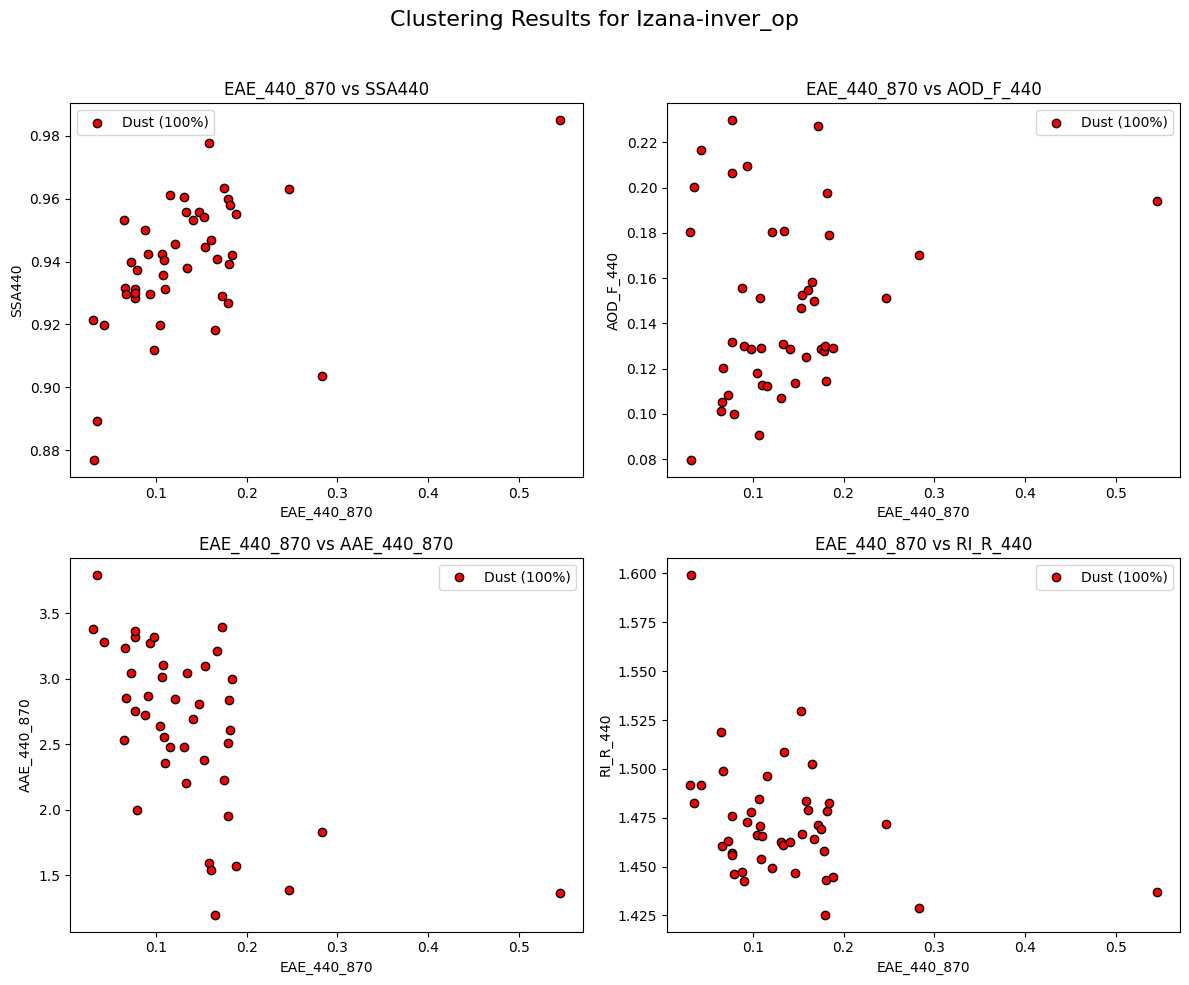

Saved plot for Izana-inver_op...


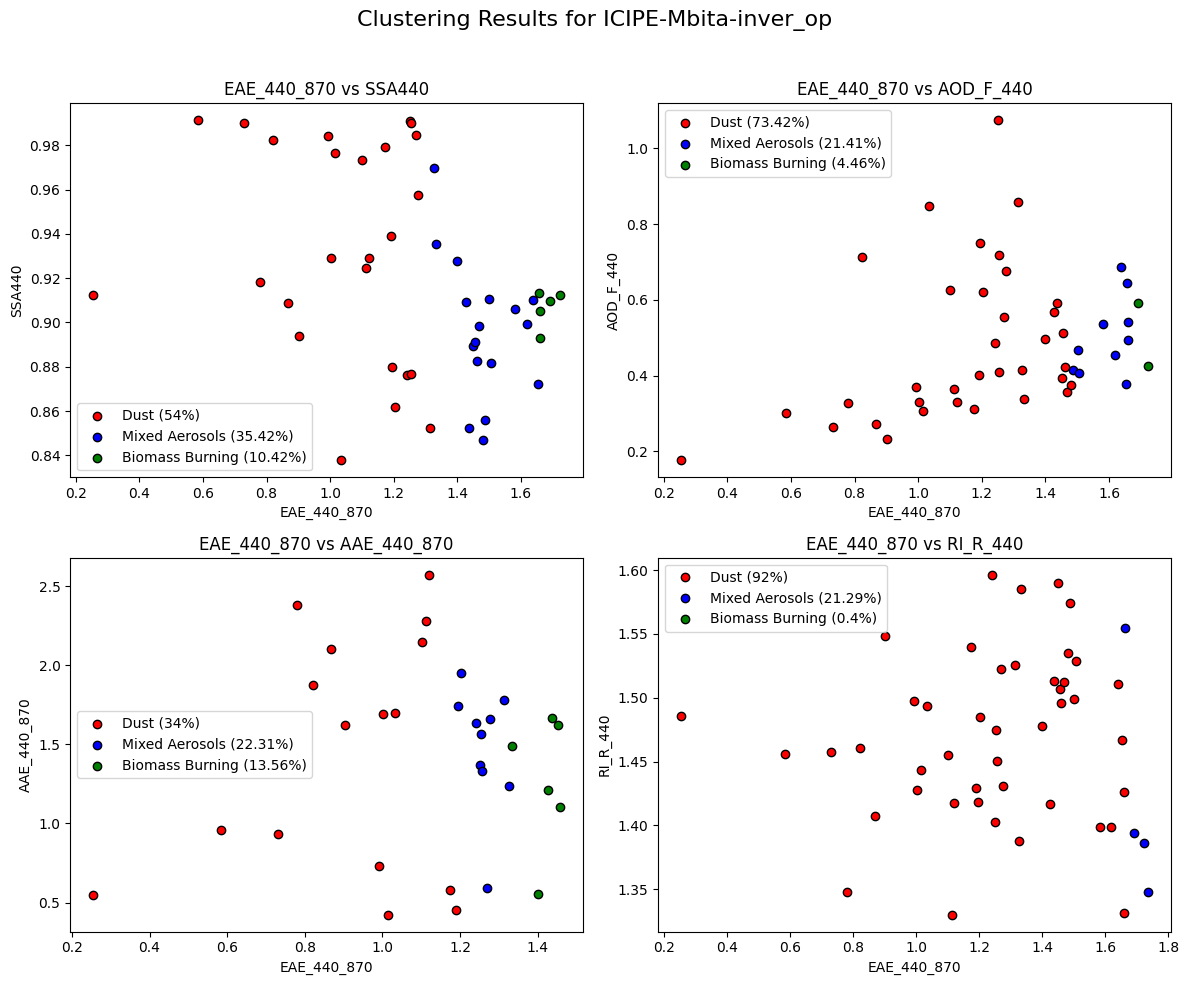

Saved plot for ICIPE-Mbita-inver_op...


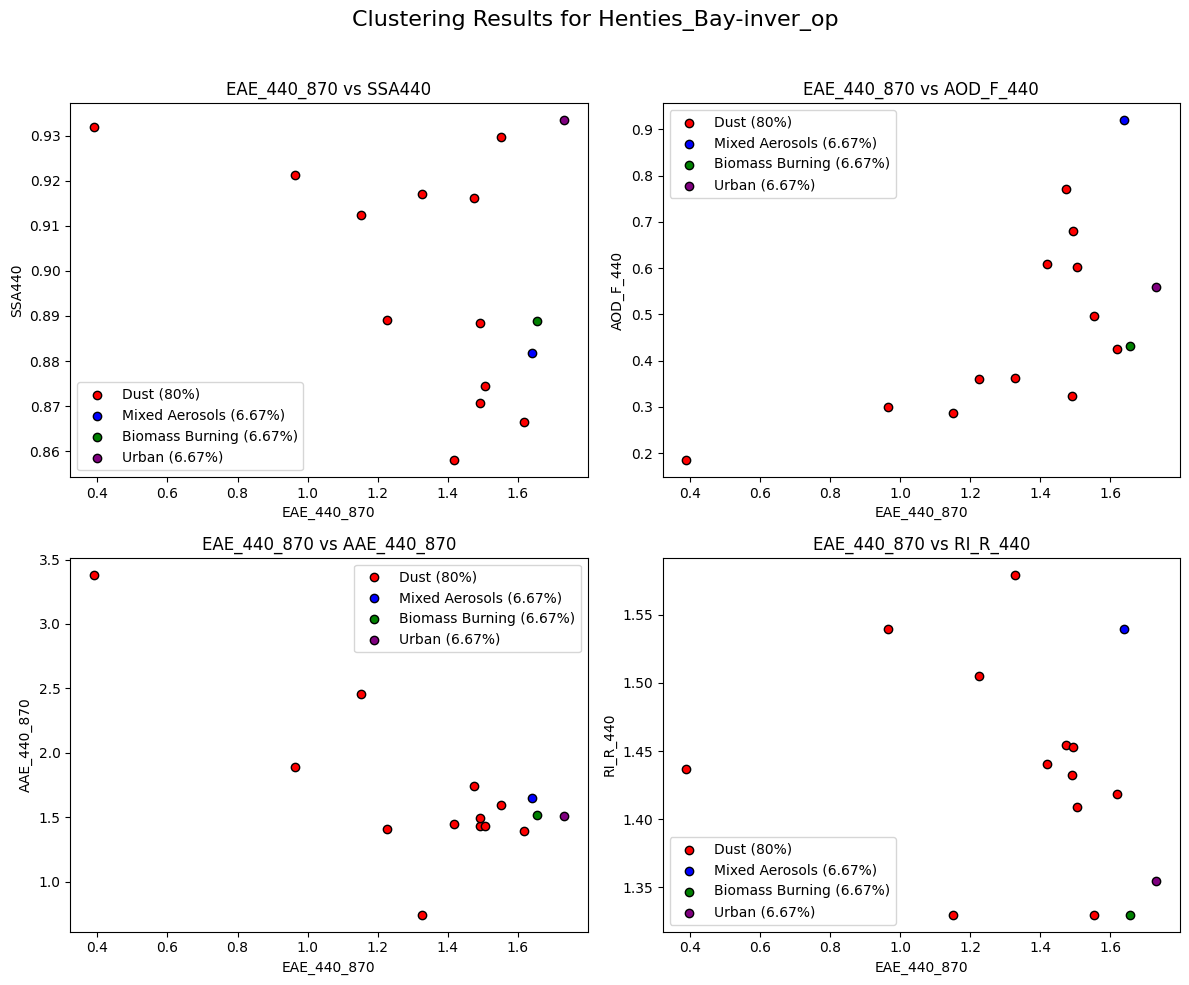

Saved plot for Henties_Bay-inver_op...


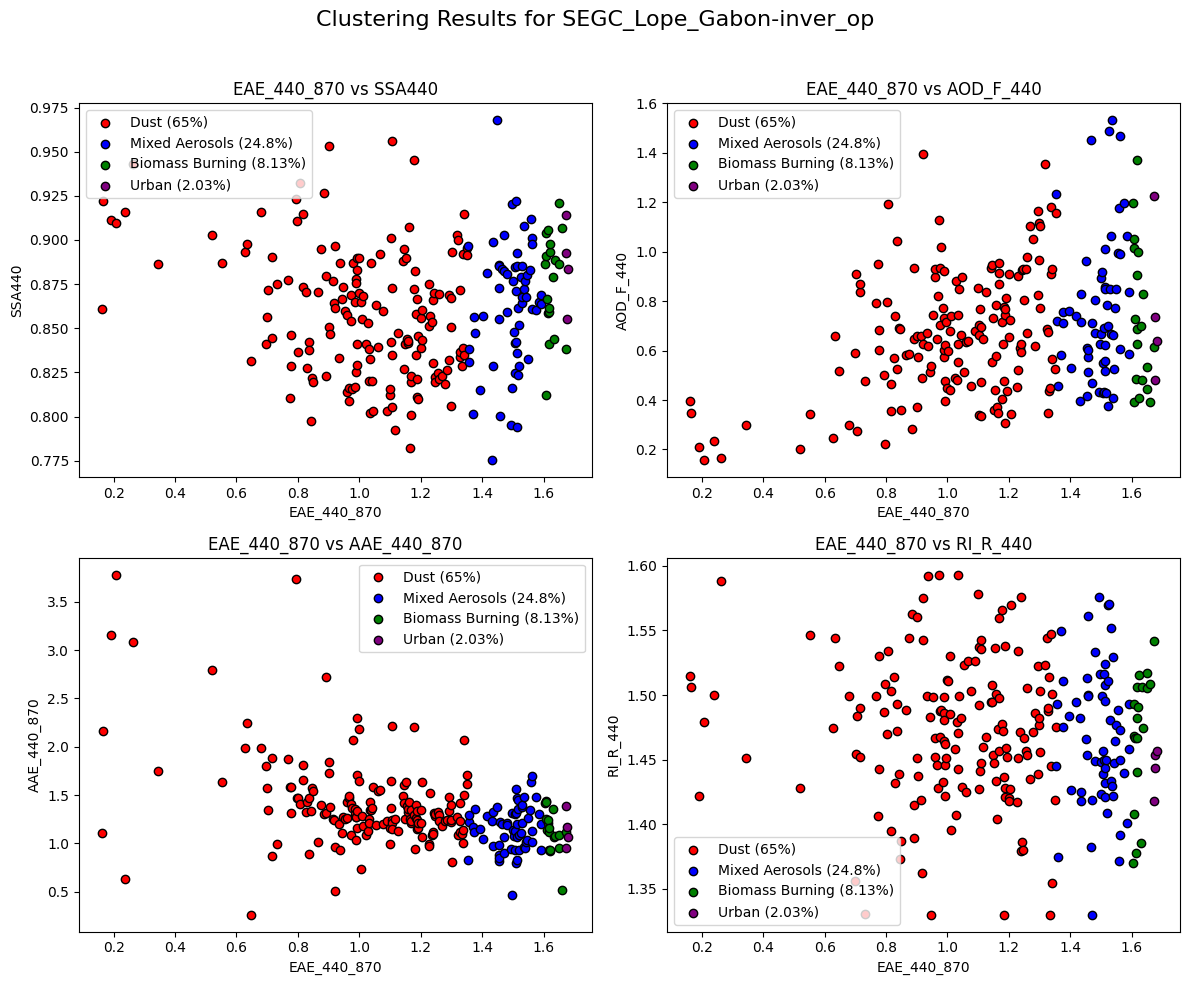

Saved plot for SEGC_Lope_Gabon-inver_op...


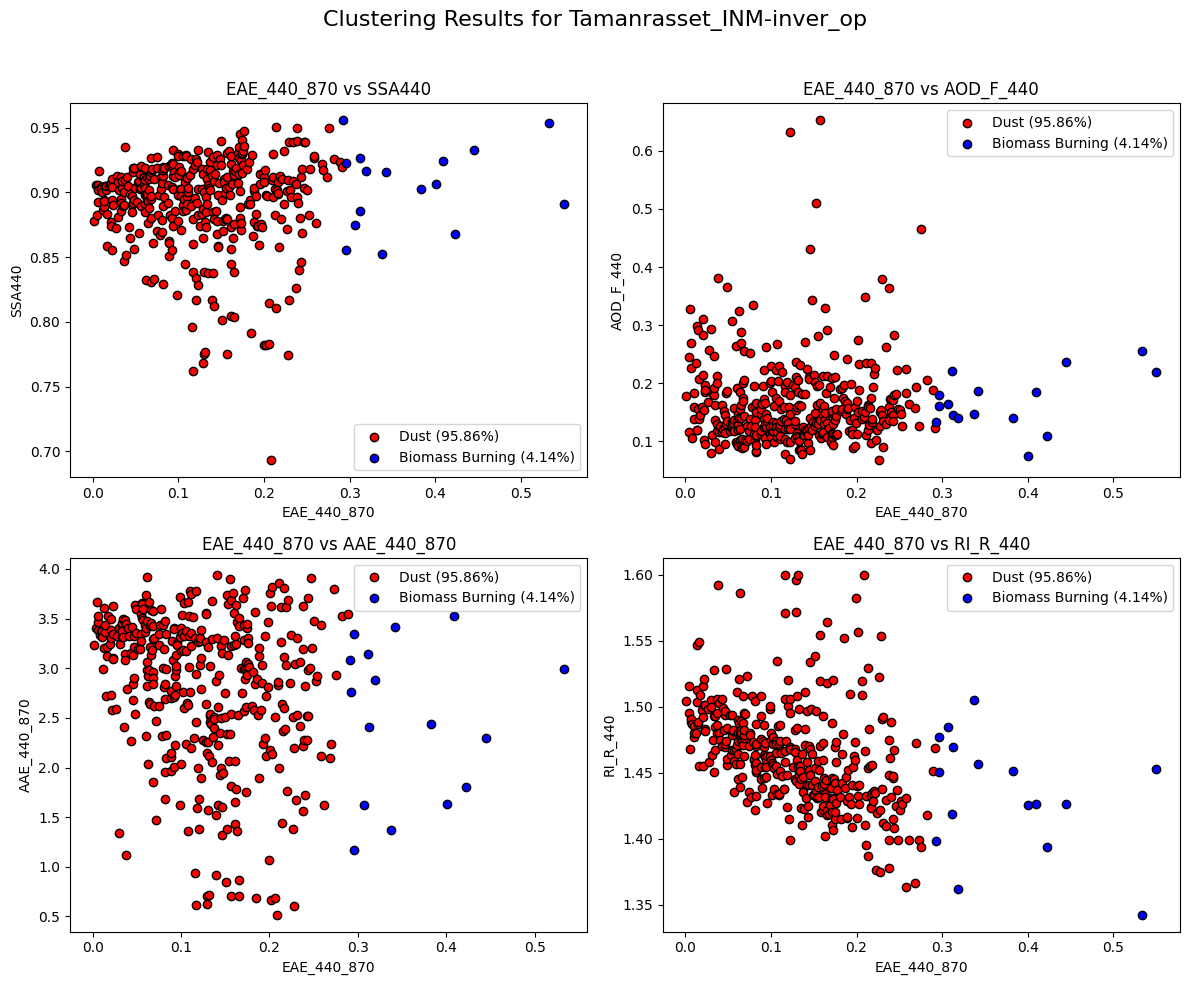

Saved plot for Tamanrasset_INM-inver_op...


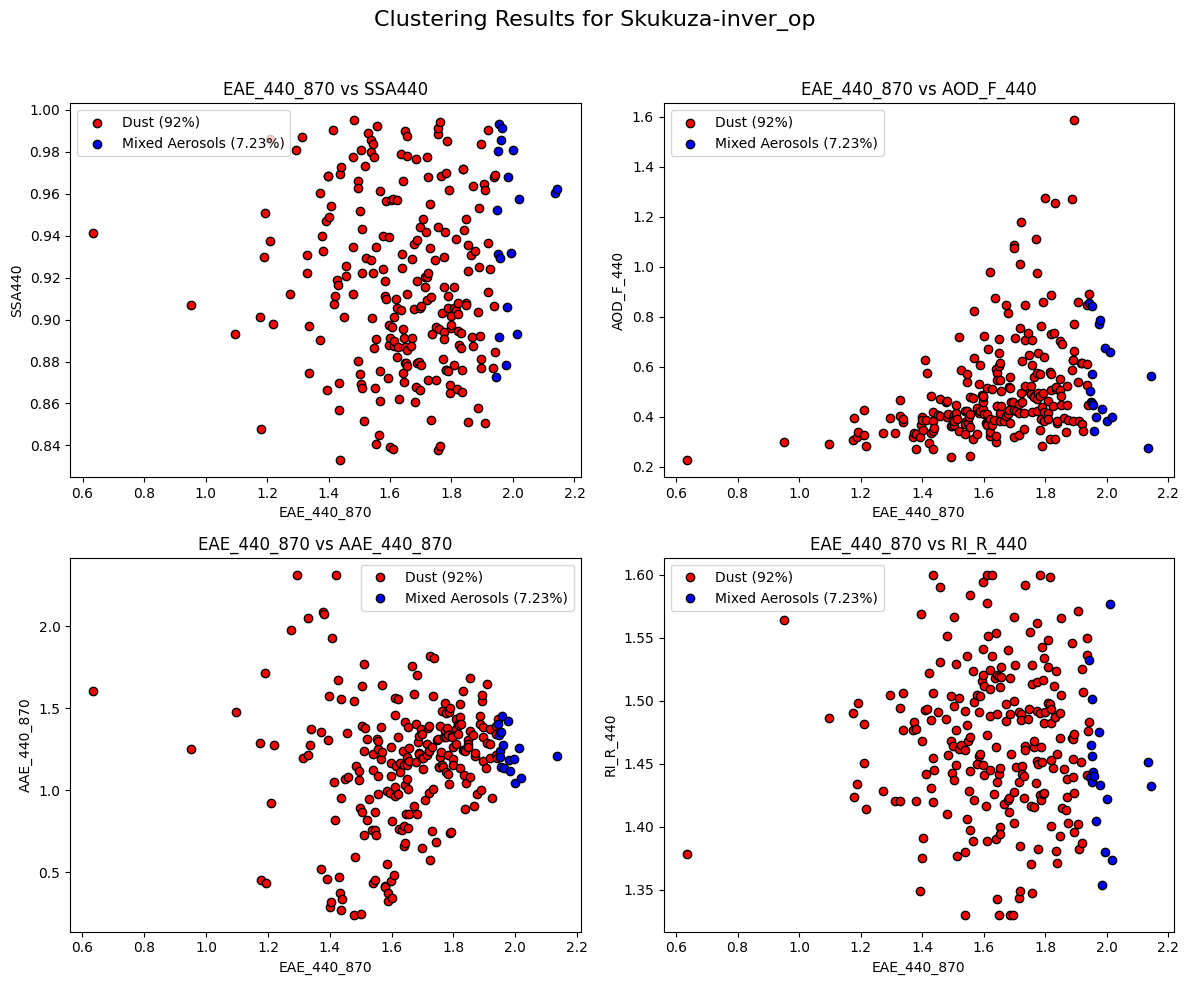

Saved plot for Skukuza-inver_op...


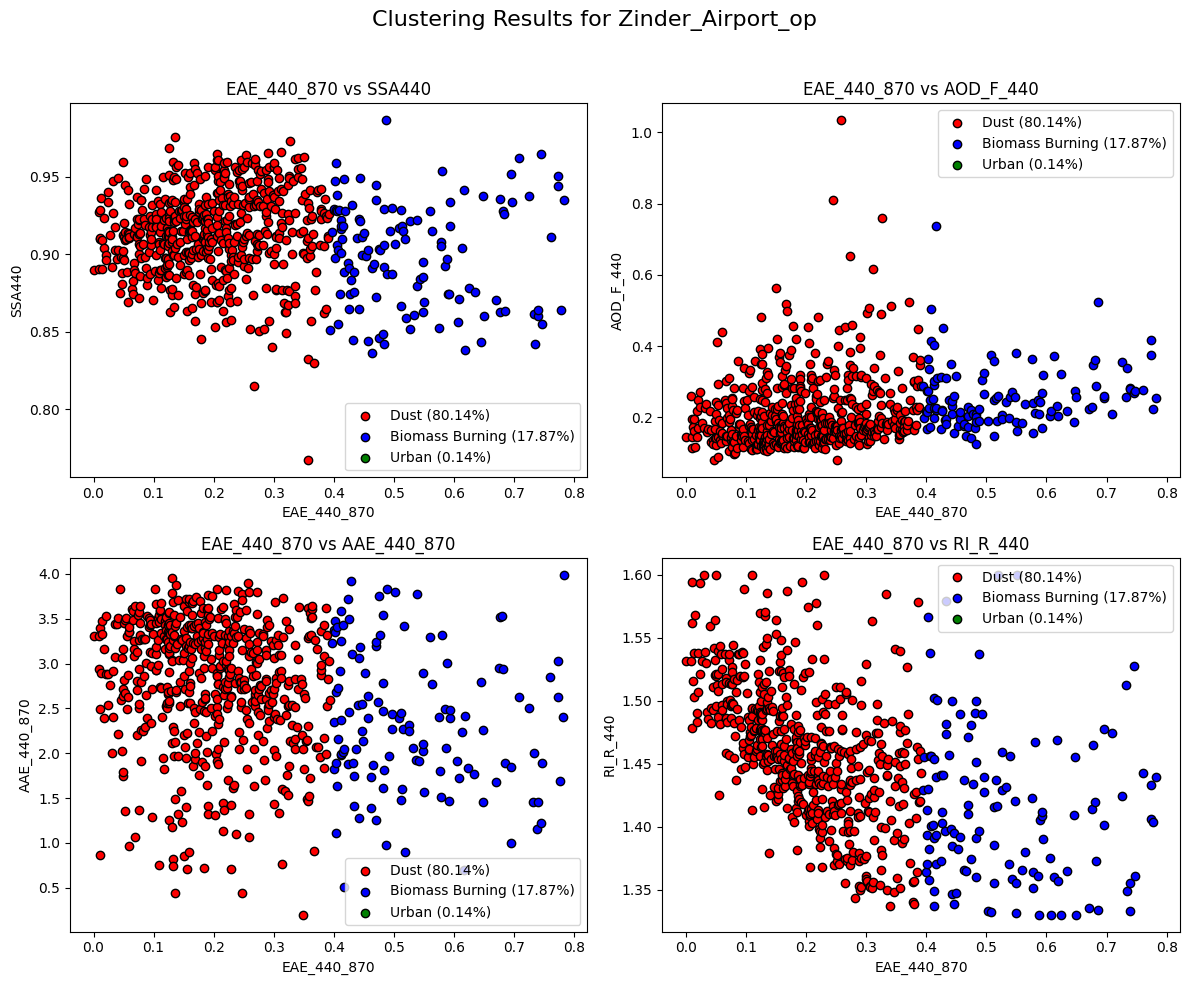

Saved plot for Zinder_Airport_op...


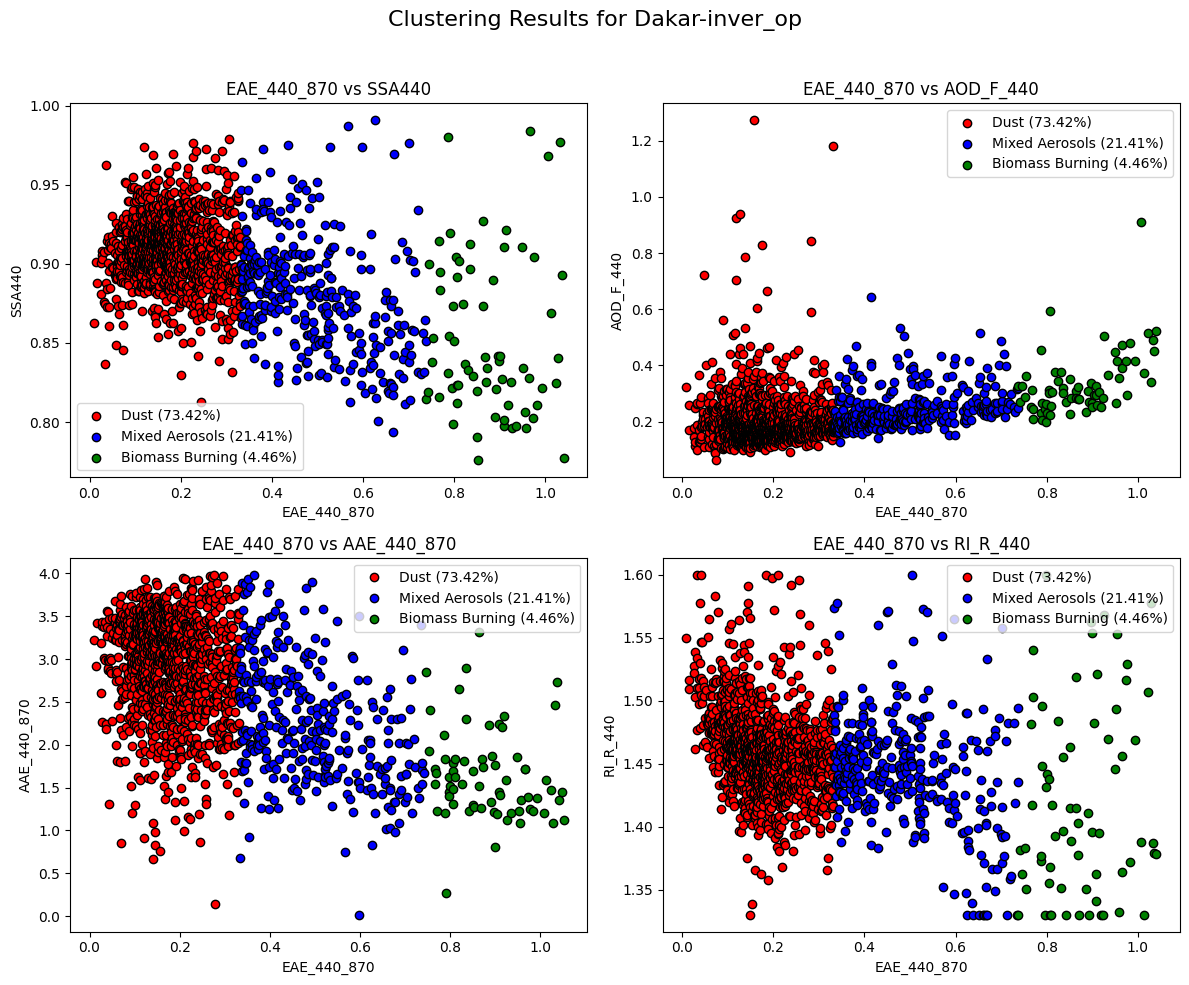

Saved plot for Dakar-inver_op...


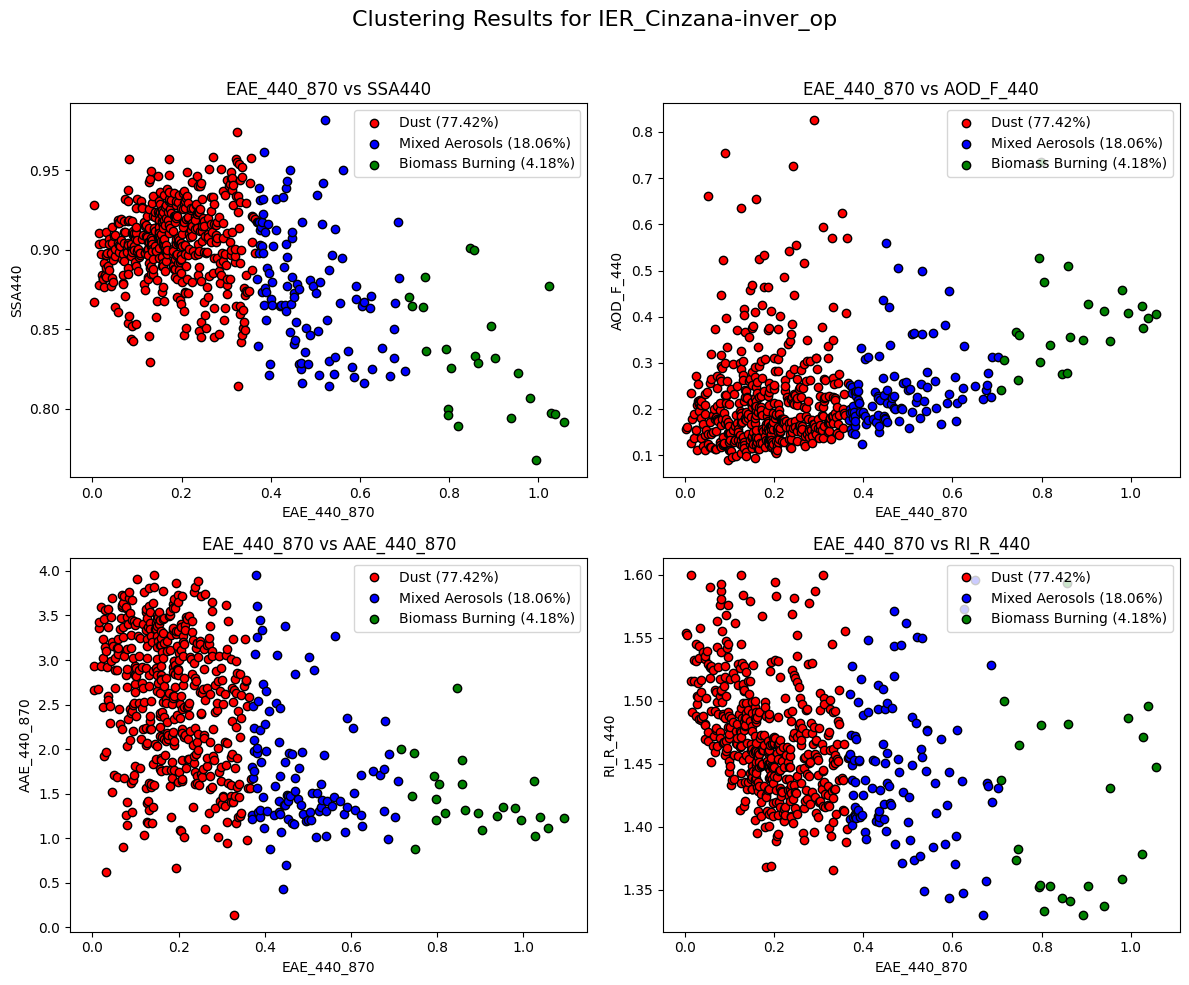

Saved plot for IER_Cinzana-inver_op...


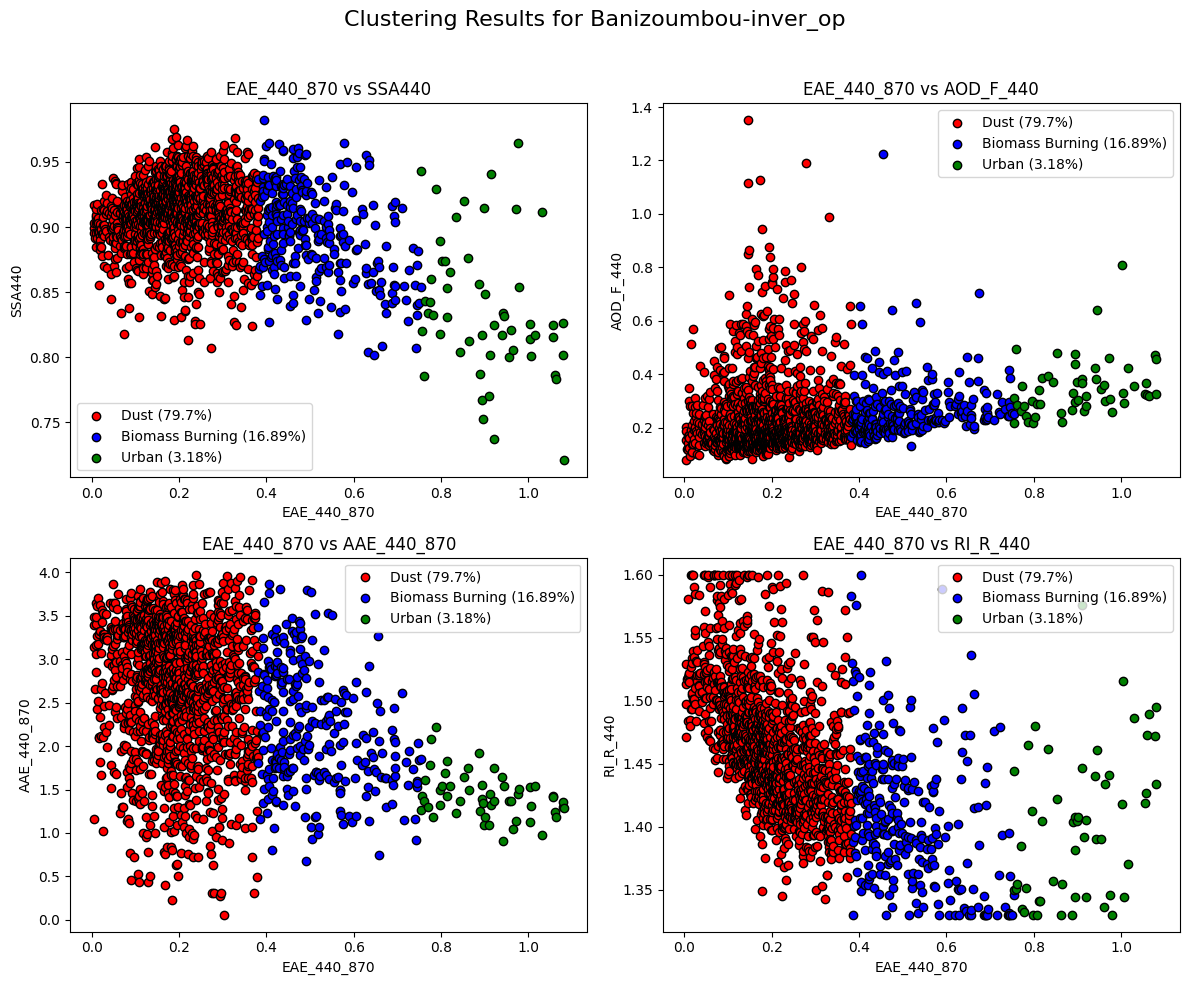

Saved plot for Banizoumbou-inver_op...


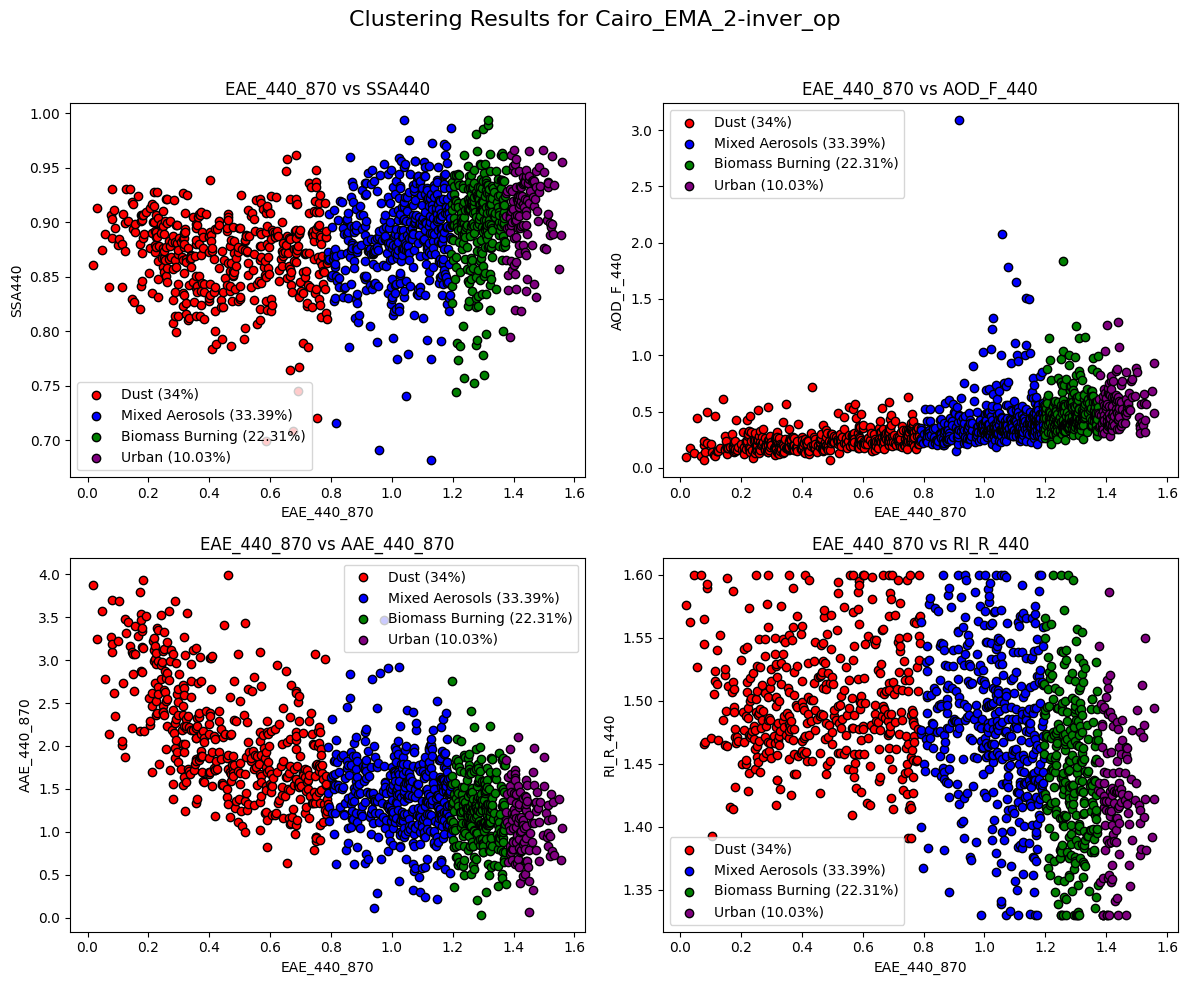

Saved plot for Cairo_EMA_2-inver_op...


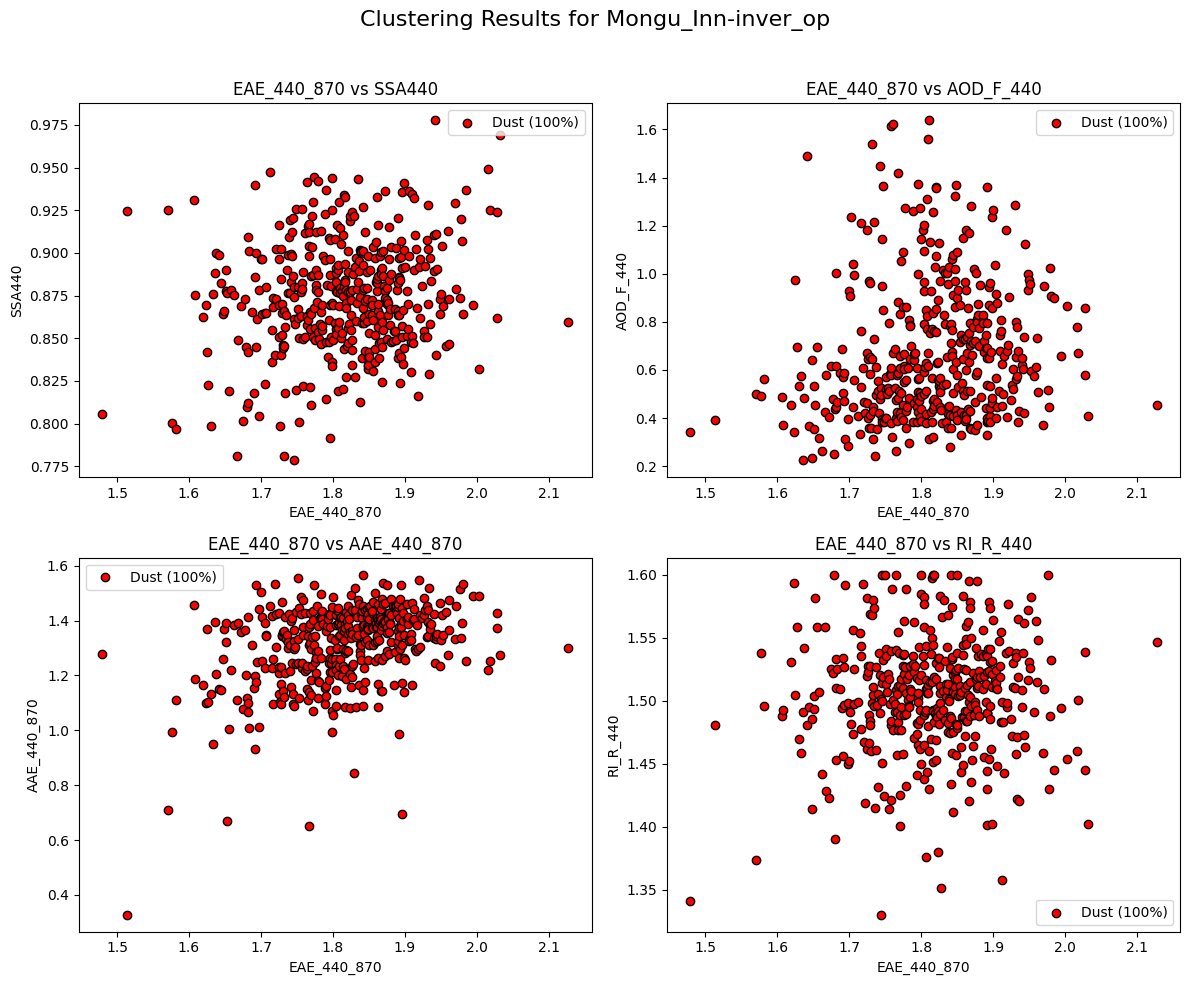

Saved plot for Mongu_Inn-inver_op...


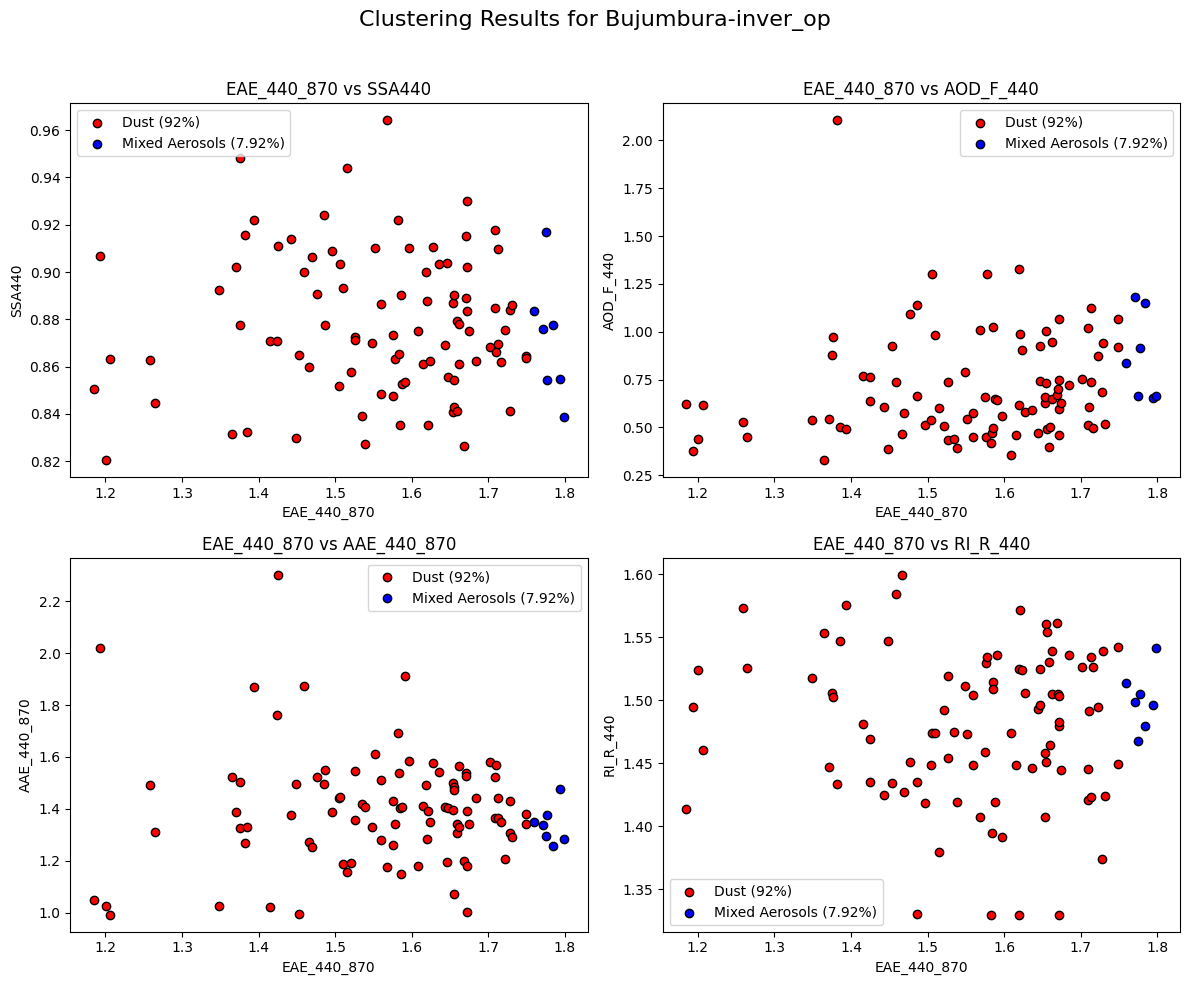

Saved plot for Bujumbura-inver_op...


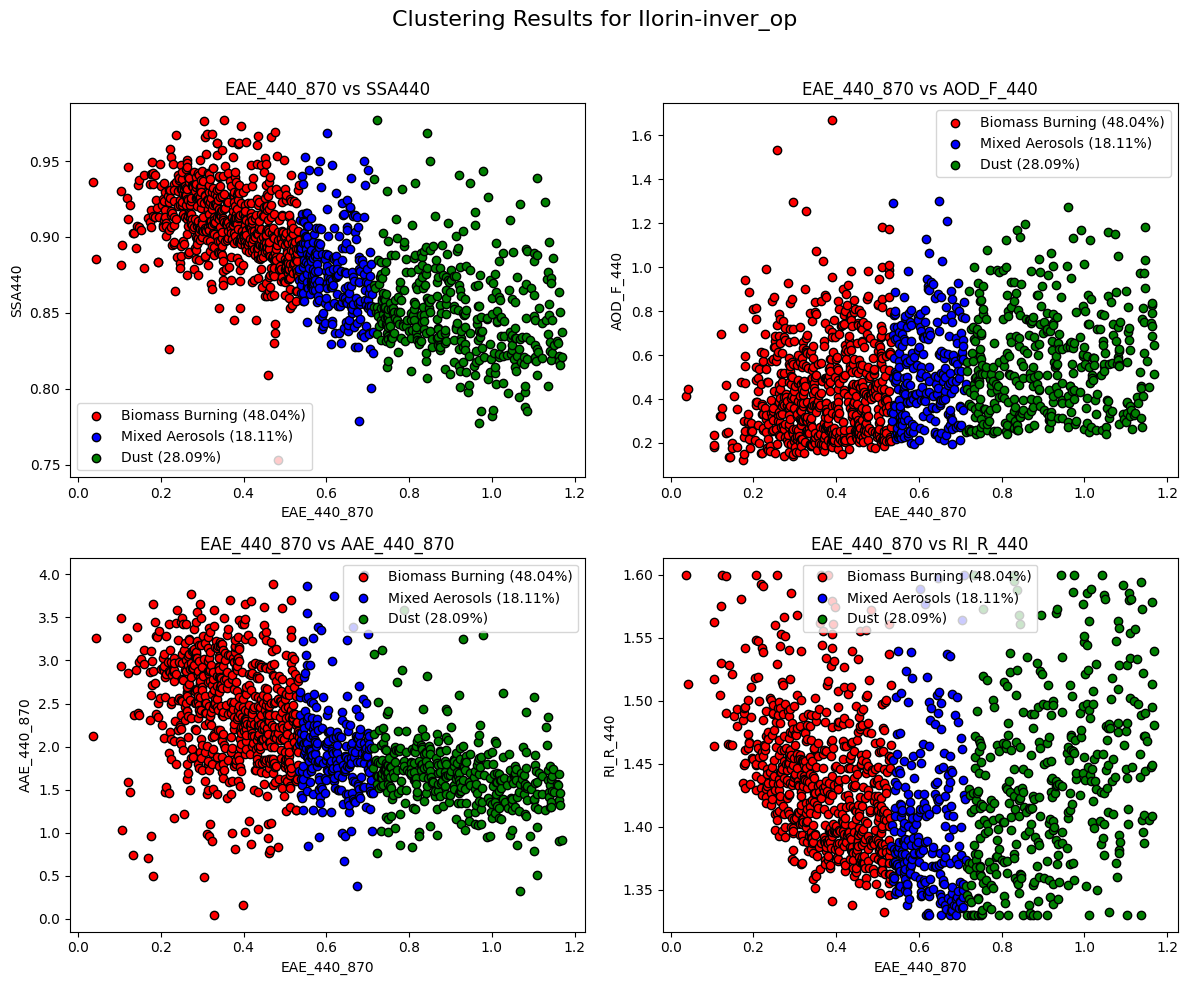

Saved plot for Ilorin-inver_op...


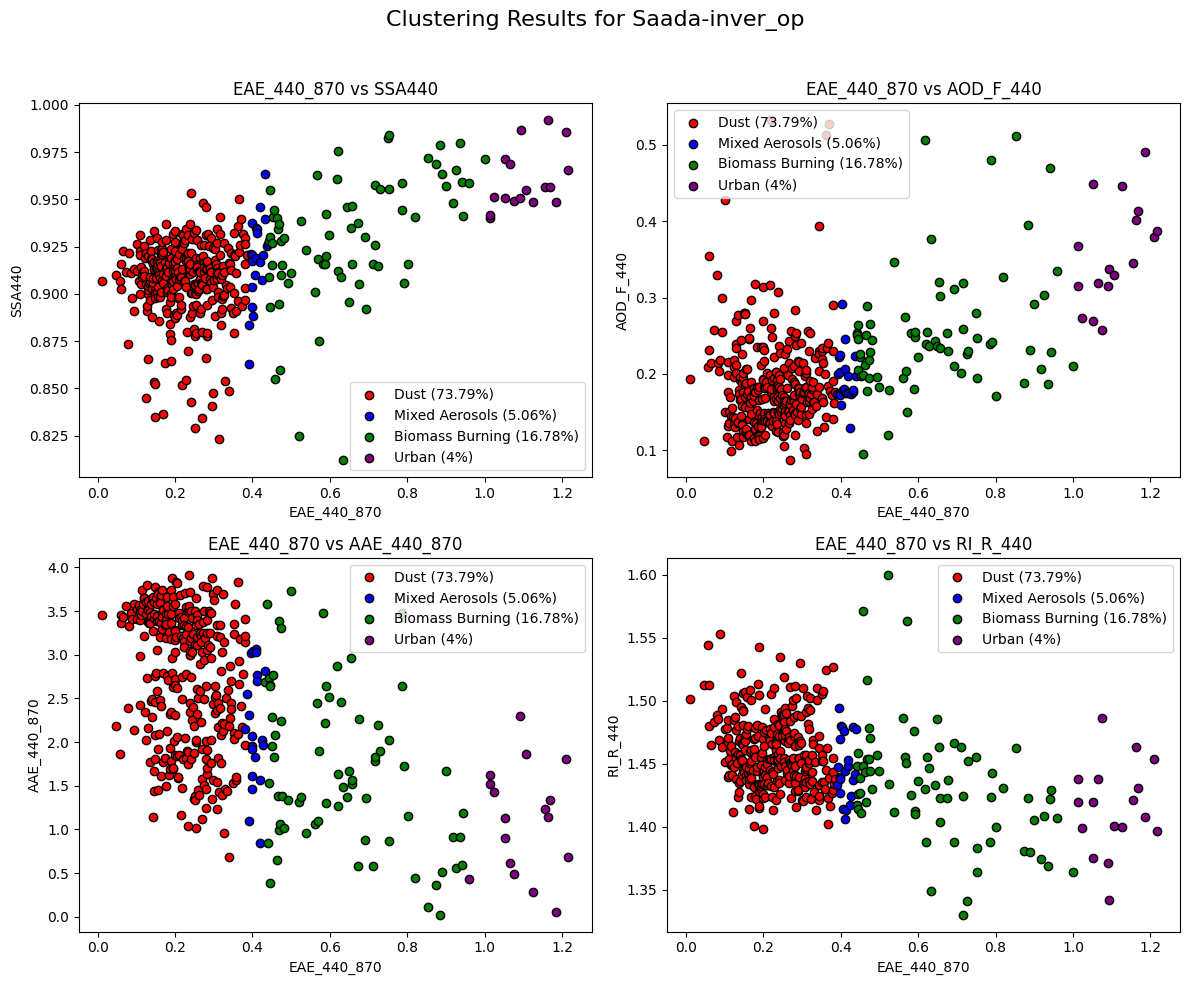

Saved plot for Saada-inver_op...


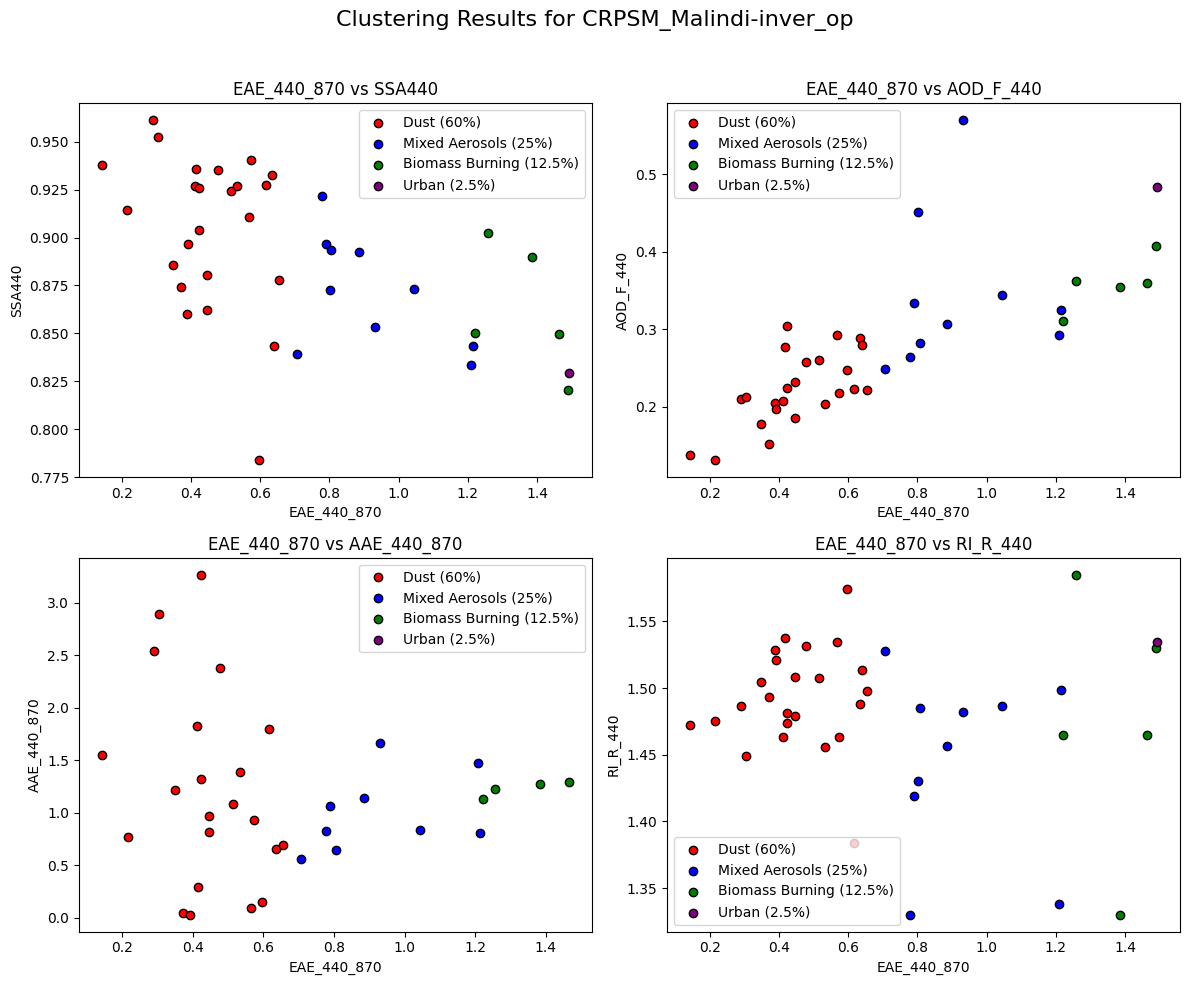

Saved plot for CRPSM_Malindi-inver_op...


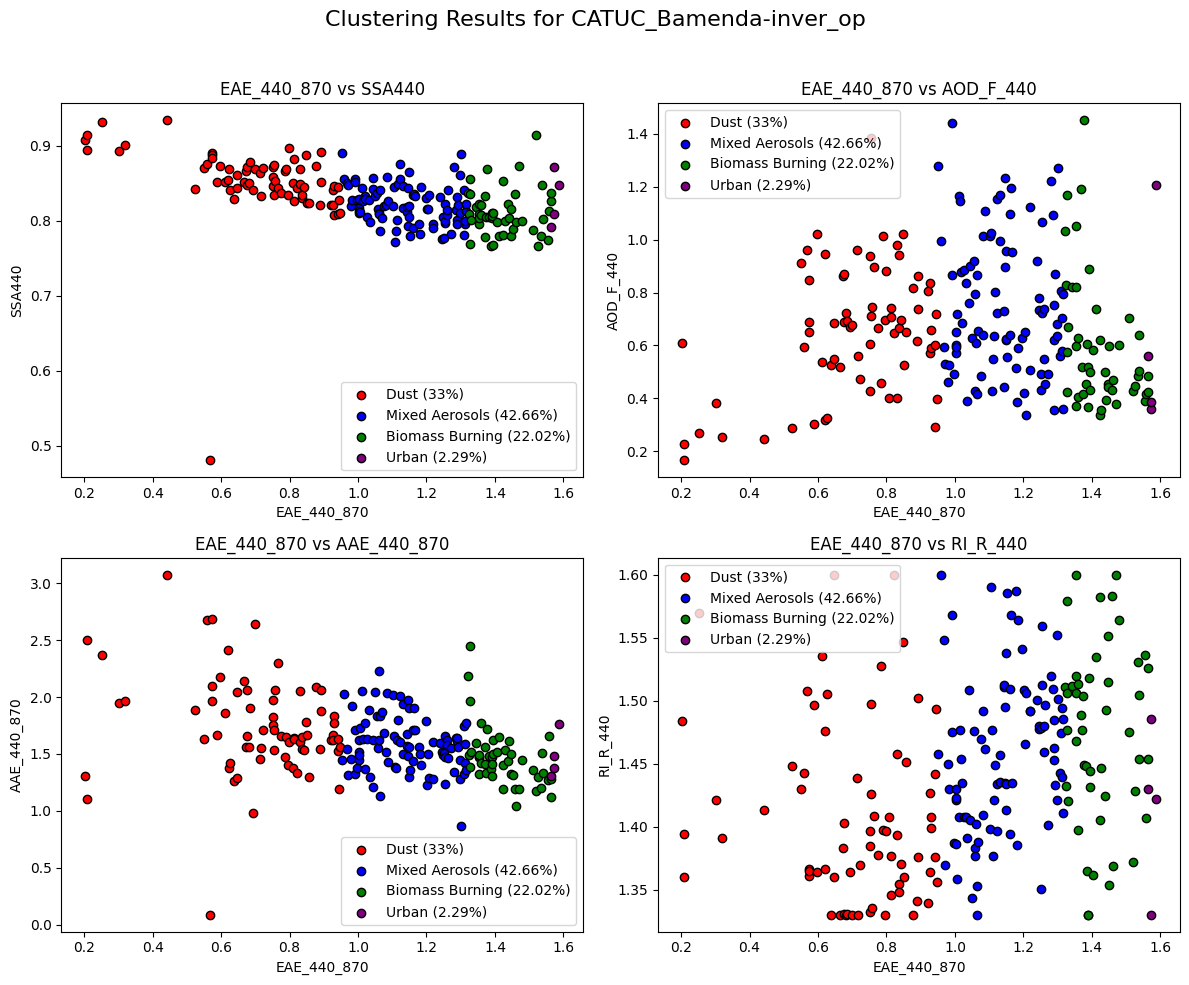

Saved plot for CATUC_Bamenda-inver_op...


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define folder paths
data_folder_path = "/content/drive/MyDrive/Results-Africa/"
output_folder_path = "/content/drive/MyDrive/africa17_plots"

# Ensure the output folder exists
os.makedirs(output_folder_path, exist_ok=True)

# Define feature pairs for plotting
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'RI_R_440')
]

# Define the fixed cluster data with cluster labels and percentages for each dataset
fixed_cluster_data = {
    "Izana-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 100)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 100)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 100)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 100)}
    },
    "ICIPE-Mbita-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 54), 1: ('Mixed Aerosols', 35.42), 2: ('Biomass Burning', 10.42)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 34), 1: ('Mixed Aerosols', 22.31), 2: ('Biomass Burning', 13.56)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 21.29), 2: ('Biomass Burning', 0.4)}
    },
    "Henties_Bay-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 80), 1: ('Mixed Aerosols', 6.67), 2: ('Biomass Burning', 6.67), 3: ('Urban', 6.67)}
    },
    "SEGC_Lope_Gabon-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 65), 1: ('Mixed Aerosols', 24.8), 2: ('Biomass Burning', 8.13), 3: ('Urban', 2.03)}
    },
    "Tamanrasset_INM-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 95.86), 1: ('Biomass Burning', 4.14)}
    },
    "Skukuza-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.23)}
    },
    "Zinder_Airport_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 80.14), 1: ('Biomass Burning', 17.87), 2: ('Urban', 0.14)}
    },
    "Dakar-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 73.42), 1: ('Mixed Aerosols', 21.41), 2: ('Biomass Burning', 4.46)}
    },
    "IER_Cinzana-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 77.42), 1: ('Mixed Aerosols', 18.06), 2: ('Biomass Burning', 4.18)}
    },
    "Banizoumbou-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 79.7), 1: ('Biomass Burning', 16.89), 2: ('Urban', 3.18)}
    },
    "Cairo_EMA_2-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 34), 1: ('Mixed Aerosols', 33.39), 2: ('Biomass Burning', 22.31), 3: ('Urban', 10.03)}
    },
    "Mongu_Inn-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 100)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 100)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 100)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 100)}
    },
    "Bujumbura-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 92), 1: ('Mixed Aerosols', 7.92)}
    },
    "Ilorin-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs AOD_F_440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs AAE_440_870': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)},
        'EAE_440_870 vs RI_R_440': {0: ('Biomass Burning', 48.04), 1: ('Mixed Aerosols', 18.11), 2: ('Dust', 28.09)}
    },
    "Saada-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 73.79), 1: ('Mixed Aerosols', 5.06), 2: ('Biomass Burning', 16.78), 3: ('Urban', 4)}
    },
    "CRPSM_Malindi-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 60), 1: ('Mixed Aerosols', 25), 2: ('Biomass Burning', 12.5), 3: ('Urban', 2.5)}
    },
    "CATUC_Bamenda-inver_op": {
        'EAE_440_870 vs SSA440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs AOD_F_440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs AAE_440_870': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)},
        'EAE_440_870 vs RI_R_440': {0: ('Dust', 33), 1: ('Mixed Aerosols', 42.66), 2: ('Biomass Burning', 22.02), 3: ('Urban', 2.29)}
    }
}

# Fixed colors for clusters
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}

def plot_clusters(data, feature_pairs, dataset_name, fixed_cluster_data):
    """Create subplots for clustering results for a dataset and save the figure."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Clustering Results for {dataset_name}", fontsize=16)

    for idx, (x_feature, y_feature) in enumerate(feature_pairs):
        ax = axs[idx // 2, idx % 2]

        # Prepare data for plotting
        X = data[[x_feature, y_feature]].copy()

        # Sort data based on aerosol knowledge
        if x_feature == 'EAE_440_870' and y_feature == 'SSA440':
            X.sort_values(by=[x_feature, y_feature], ascending=[True, False], inplace=True)
        elif x_feature == 'EAE_440_870' and y_feature == 'AOD_F_440':
            X.sort_values(by=[x_feature, y_feature], ascending=[True, False], inplace=True)
        elif x_feature == 'EAE_440_870' and y_feature == 'AAE_440_870':
            X.sort_values(by=[x_feature, y_feature], ascending=[True, True], inplace=True)
        elif x_feature == 'EAE_440_870' and y_feature == 'RI_R_440':
            X.sort_values(by=[x_feature, y_feature], ascending=[True, True], inplace=True)

        total_points = len(X)
        start_index = 0

        # Get feature pair specific cluster data
        feature_pair_key = f'{x_feature} vs {y_feature}'
        cluster_data = fixed_cluster_data[dataset_name][feature_pair_key]

        # Plot data based on fixed cluster percentages
        for cluster_id, (label, percentage) in cluster_data.items():
            num_points = int(total_points * (percentage / 100))
            end_index = start_index + num_points
            cluster_data_subset = X.iloc[start_index:end_index]

            ax.scatter(cluster_data_subset[x_feature], cluster_data_subset[y_feature],
                       c=cluster_colors.get(cluster_id, 'gray'),
                       label=f'{label} ({percentage}%)', edgecolor='k')
            start_index = end_index

        ax.set_title(f'{x_feature} vs {y_feature}')
        ax.set_xlabel(x_feature)
        ax.set_ylabel(y_feature)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    save_path = os.path.join(output_folder_path, f"{dataset_name}_clustering_results.png")
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Saved plot for {dataset_name}...")

# Iterate through all datasets in the fixed cluster data dictionary
for dataset_name in fixed_cluster_data.keys():
    try:
        # Load data
        data_file_path = os.path.join(data_folder_path, f"{dataset_name}.csv")
        data = pd.read_csv(data_file_path)

        # Plot clusters based on fixed percentages
        plot_clusters(data, feature_pairs, dataset_name, fixed_cluster_data)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")


In [ ]:
print(X[:5])  # Print first few rows to inspect


[[0.27126 0.9161 ]
 [0.24403 0.9089 ]
 [0.29834 0.8942 ]
 [0.23102 0.8809 ]
 [0.19405 0.9038 ]]


In [ ]:
try:
    file_path = '/content/drive/MyDrive/Calculated_data17/Banizoumbou-inver_op/cluster_prediction.csv'


    df = pd.read_csv(file_path)
    if 'Cluster' not in df.columns:
        raise ValueError("Column 'Cluster' is missing")
except Exception as e:
    print(f"Error loading file: {e}")

# Read the CSV file
df = pd.read_csv(file_path)

# Print out all column names
print("Columns available:", df.columns)

# Check if 'Cluster' or similar column exists
if any(col.lower() == 'cluster' for col in df.columns):
    # Handle the column correctly
    df['Cluster'] = df[[col for col in df.columns if col.lower() == 'cluster'][0]]
else:
    raise ValueError("No column named 'Cluster' found")



Error loading file: Column 'Cluster' is missing
Columns available: Index(['Cluster_Label'], dtype='object')


ValueError: No column named 'Cluster' found

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
